In [1]:
# Importing Required Python Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [2]:
# Reading in the dataset & getting its info
df = pd.read_csv('prepared_data.csv',index_col='Date',parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2016-10-01 to 2019-09-01
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Vol       72 non-null     float64
 1   Category  72 non-null     object 
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


In [3]:
# Segregating the dataset for buiscuits and Chocolate
bis = df.loc[df['Category'] == 'BISCUIT']
choc = df.loc[df['Category'] != 'BISCUIT']

In [4]:
# Importing keras from tensorflow
from tensorflow import keras

### Observations:
### 1) As we observed earlier log_biscuit_volume series is Non-Stationary. lets see if we can make it stationary by taking diffrence of order = 1.

In [5]:
# Converting the biscuit volume series into pandas series
bis_s = (bis['Vol']).copy()

In [6]:
# Taking log of the biscuit volume series to reduce variance
bis_log = np.log10(bis_s)

In [7]:
# Taking the difference = 1 of the log series & removing nan values
bis_log_diff = (bis_log.diff(1)).dropna()

In [8]:
len(bis_log_diff)

35

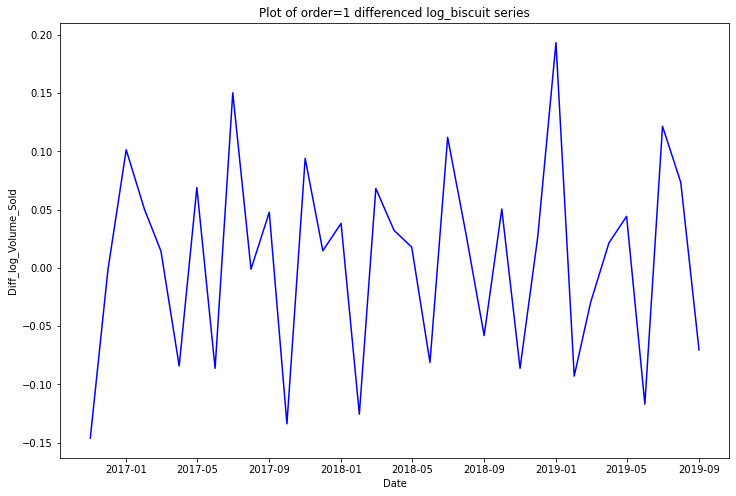

In [9]:
# plotting the log biscuit  differenced series of order 1
plt.figure(figsize=(12,8))
plt.plot(bis_log_diff,color='blue')
plt.xlabel('Date')
plt.ylabel('Diff_log_Volume_Sold')
plt.title('Plot of order=1 differenced log_biscuit series')
plt.show()

### Observations:
### 1) The above series appears to be stationary. but we need to further apply statistical test to check for unit root stationarity. 

### Running Stationarity tests on the differenced series.

In [10]:
#Defining function to test for stationarity  of the seasonally differenced series using KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    #kpss_output
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [11]:
# Applying KPSS test to check for unit root of the bis_log_diff series
kpss_test(bis_log_diff)

Results of KPSS Test:
Test Statistic            0.500000
p-value                   0.041667
Lags Used                34.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [12]:
#Defining function to test for stationarity  of the seasonally differenced series using adf test test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [13]:
# Applying adf test to check for unit root of the bis_log_diff series
adf_test(bis_log_diff)

Results of Dickey-Fuller Test:
Test Statistic                -5.910176e+00
p-value                        2.650256e-07
#Lags Used                     4.000000e+00
Number of Observations Used    3.000000e+01
Critical Value (1%)           -3.669920e+00
Critical Value (5%)           -2.964071e+00
Critical Value (10%)          -2.621171e+00
dtype: float64


### Observations: 
### 1) From the above tests it appears that series is more or less stationary. Lets try to plot its ACF & PACF

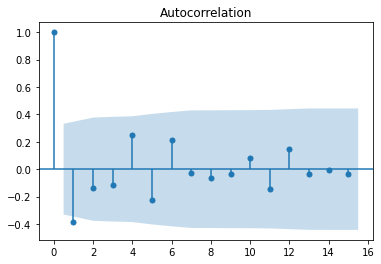

In [14]:
# Plotting the acf of the differenced log biscuit series
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(bis_log_diff, lags=15)
plt.show()

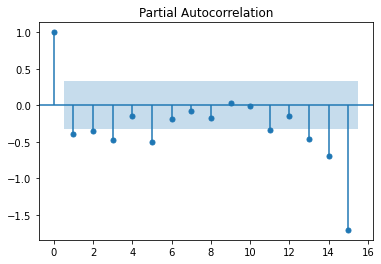

In [15]:
# Plotting the pacf of the differenced log biscuit series
sm.graphics.tsa.plot_pacf(bis_log_diff, lags=15)
plt.show()

### Observations:
### 1) The above plots also reveal that differenced log_bis series is stationary.
### 2) The PACF plots show that 5 lags may be useful as features for predicting the present values.

In [16]:
# Function to transform series into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    ''' Transform a time series to a training and the test set'''
    df = pd.DataFrame(data)
    cols = list()
# input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
# put it all together
    agg = pd.concat(cols, axis=1)
# drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.iloc[:,:-n_out] , agg.iloc[:,-n_out:]

In [17]:
# Converting bis_log_diff series to the X_train & y_train with lag 5 values as features
X, y = series_to_supervised(bis_log_diff, n_in=5, n_out=1 )

In [18]:
# Renaming the columns of the X_train
X.columns = ['Lag_5', 'Lag_4', 'Lag_3', 'Lag_2', 'Lag_1']

In [19]:
X

,Lag_5,Lag_4,Lag_3,Lag_2,Lag_1
Date,,,,,
2017-04-01,-0.146061,-0.001623,0.101295,0.050263,0.014381
2017-05-01,-0.001623,0.101295,0.050263,0.014381,-0.084196
2017-06-01,0.101295,0.050263,0.014381,-0.084196,0.068877
2017-07-01,0.050263,0.014381,-0.084196,0.068877,-0.086267
2017-08-01,0.014381,-0.084196,0.068877,-0.086267,0.150211
2017-09-01,-0.084196,0.068877,-0.086267,0.150211,-0.001160
2017-10-01,0.068877,-0.086267,0.150211,-0.001160,0.047680
2017-11-01,-0.086267,0.150211,-0.001160,0.047680,-0.133896
2017-12-01,0.150211,-0.001160,0.047680,-0.133896,0.093957


In [20]:
len(X)

30

### In keeping with the SARIMA analysis, lets keep 6 observations in the test set, 4 in the validation & 20 in the training set.

In [21]:
# splitting the observations into training & test set
X_train, X_test = X.iloc[:24], X.iloc[24:]
y_train, y_test = y.iloc[:24], y.iloc[24:]

In [22]:
# splitting the training set  into training & validation set
X_train, X_val = X_train.iloc[:20], X_train.iloc[20:]
y_train, y_val = y_train.iloc[:20], y_train.iloc[20:]

In [23]:
len(X_train),len(X_val),len(X_test)

(20, 4, 6)

In [24]:
# importing hyperparameter tuning library Optuna
import optuna

In [25]:
# Importing relevant packages
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from math import sqrt

### Tuning hyper-parameters of the MLP Neural Net using Optuna

In [26]:
# defining the objective function
def objective_wrappper_keras_eq(X_tr, y_tr, X_val, y_val):
    '''
    Optimizes Keras neural net(with equal no. of neurons in each layer) best parameters 
    on the given training set: X_tr, y_tr using validation set: X_val,y_val 
    
    '''
    def objective(trial):
        # Tuning the learning rate
        s = trial.suggest_int('step',2,5)
        def exponential_decay_fn(epoch): # 
            return 0.01 * 0.1**(epoch /s )     
        
        # Building model & searching for the best no. of neural units per layer.
        no_units = trial.suggest_int('no._units',100,500)# No. of Neurons in each layer
        model = keras.models.Sequential()
        model.add(keras.layers.InputLayer(input_shape=X_tr.shape[1:]))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dense(units=no_units,activation='selu',
                                     kernel_initializer='lecun_normal')) # For self normalization
        #model.add(keras.layers.Dense(units=no_units,activation='selu',
                                     #kernel_initializer='lecun_normal'))
        model.add(keras.layers.Dense(units=1))
    
            
        # Compiling the model
        model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Nadam(beta_1=0.9, beta_2=0.999)
                      ,metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
        # Defining the Callbacks
        checkpoint_cb = keras.callbacks.ModelCheckpoint('best_model.h5',save_best_only=True) # 1st Callback
        early_stopping_cb = keras.callbacks.EarlyStopping(patience=30,restore_best_weights=True) # 2nd Callback, Stop if validation score doen't improve for
        # 30 epochs        
        lr_scheduler_cb = keras.callbacks.LearningRateScheduler(exponential_decay_fn)# 3rd Callback
        
        #Fitting the model
        model.fit(X_tr, y_tr, epochs=200, validation_data=(X_val,y_val), batch_size=4,
             callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler_cb], shuffle=False)
    
        # Loading the best model 
        model_best = keras.models.load_model('best_model.h5')
    
        # Computing the roc_auc_score for the validation set
        error = sqrt(mean_squared_error(y_val, model_best.predict(X_val)))
        global best_error
        # Updating best_error score
        if error < best_error:
            best_error = error
            model_best.save('Best_model_Selu_eq_Learn.h5')
        
        return error
    
    return objective

In [27]:
# Defining the evaluation function for study's best parameters
def study_func(X_tr, y_tr, X_v, y_v, obj_func, n_trials=200):
    ''' Computes the best hyper parameters of the Neural net using the Training set(X_tr,y_tr) & Validation set
    (X_v,y_v) & returns Optuna's study's best score & clasifier parameters'''
    
    study = optuna.create_study(direction='minimize')
    study.optimize(obj_func(X_tr, y_tr, X_v, y_v), n_trials)
    best_score = study.best_value
    best_params = study.best_params
    return (best_score, best_params)
 

In [38]:
# Extracting the best model parameters and best study score
best_error = np.inf
best_study_score, best_study_params = study_func(X_train, y_train, X_val, y_val, objective_wrappper_keras_eq)

[I 2021-02-27 17:58:05,710] A new study created in memory with name: no-name-b2fd05e2-7981-4b50-9cf3-16491f17745a


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 0.1649 - root_mean_squared_error: 0.4061 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1091
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0614 - root_mean_squared_error: 0.2479 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1227
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0101 - root_mean_squared_error: 0.1003 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1247
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0076 - root_mean_squared_error: 0.0873 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1245
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0059 - root_mean_squared_error: 0.0767 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1236
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0049 - root_mean_squared_error: 0.0699 - val_loss: 0.0150 - val_root_mean_squared

5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - root_mean_squared_error: 0.0586 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0855
Epoch 98/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0034 - root_mean_squared_error: 0.0586 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0862
Epoch 99/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0034 - root_mean_squared_error: 0.0586 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0869
Epoch 100/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0034 - root_mean_squared_error: 0.0586 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0876
Epoch 101/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0034 - root_mean_squared_error: 0.0586 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0884
Epoch 102/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0034 - root_mean_squared_error: 0.0586 - val_loss: 0.0079 - val_root_mean_squared_erro

[I 2021-02-27 17:58:09,515] Trial 0 finished with value: 0.07733891168400031 and parameters: {'step': 5, 'no._units': 135}. Best is trial 0 with value: 0.07733891168400031.


Epoch 1/200
5/5 [==============================] - 0s 25ms/step - loss: 0.4437 - root_mean_squared_error: 0.6661 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1004
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0372 - root_mean_squared_error: 0.1928 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0951
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0191 - root_mean_squared_error: 0.1381 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0949
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0155 - root_mean_squared_error: 0.1247 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0946
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0138 - root_mean_squared_error: 0.1175 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0943
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0130 - root_mean_squared_error: 0.1138 - val_loss: 0.0088 - val_root_mean_squared

[I 2021-02-27 17:58:11,609] Trial 1 finished with value: 0.09135437592163195 and parameters: {'step': 3, 'no._units': 162}. Best is trial 0 with value: 0.07733891168400031.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.5800 - root_mean_squared_error: 1.2570 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1412
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2437 - root_mean_squared_error: 0.4937 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1187
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0458 - root_mean_squared_error: 0.2140 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1166
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0253 - root_mean_squared_error: 0.1589 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1156
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0203 - root_mean_squared_error: 0.1423 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1146
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0183 - root_mean_squared_error: 0.1352 - val_loss: 0.0129 - val_root_mean_squared

Epoch 48/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0166 - root_mean_squared_error: 0.1288 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0936
Epoch 49/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0166 - root_mean_squared_error: 0.1288 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932
Epoch 50/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0166 - root_mean_squared_error: 0.1288 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0930
Epoch 51/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0166 - root_mean_squared_error: 0.1288 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0927
Epoch 52/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0166 - root_mean_squared_error: 0.1288 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926
Epoch 53/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0166 - root_mean_squared_error: 0.1288 - val_loss: 0.0086 - val_root_mean_sq

[I 2021-02-27 17:58:15,236] Trial 2 finished with value: 0.09167269459950612 and parameters: {'step': 3, 'no._units': 429}. Best is trial 0 with value: 0.07733891168400031.


Epoch 1/200
5/5 [==============================] - 0s 27ms/step - loss: 0.3670 - root_mean_squared_error: 0.6058 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1230
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0784 - root_mean_squared_error: 0.2800 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1191
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0230 - root_mean_squared_error: 0.1515 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1151
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0171 - root_mean_squared_error: 0.1308 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1161
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0147 - root_mean_squared_error: 0.1213 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1170
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0130 - root_mean_squared_error: 0.1139 - val_loss: 0.0139 - val_root_mean_squared

[I 2021-02-27 17:58:16,811] Trial 3 finished with value: 0.11511361426860738 and parameters: {'step': 5, 'no._units': 156}. Best is trial 0 with value: 0.07733891168400031.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.9932 - root_mean_squared_error: 1.4118 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1049
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1004 - root_mean_squared_error: 0.3168 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0802
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0394 - root_mean_squared_error: 0.1986 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0802
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0318 - root_mean_squared_error: 0.1783 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0797
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0299 - root_mean_squared_error: 0.1728 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0790
Epoch 6/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0293 - root_mean_squared_error: 0.1710 - val_loss: 0.0061 - val_root_mean_squared

[I 2021-02-27 17:58:19,440] Trial 4 finished with value: 0.06293740092760802 and parameters: {'step': 2, 'no._units': 488}. Best is trial 4 with value: 0.06293740092760802.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 0.8656 - root_mean_squared_error: 0.9304 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1546
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1821 - root_mean_squared_error: 0.4267 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1151
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0820 - root_mean_squared_error: 0.2863 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0997
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0520 - root_mean_squared_error: 0.2281 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0945
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0403 - root_mean_squared_error: 0.2009 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0925
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0349 - root_mean_squared_error: 0.1869 - val_loss: 0.0084 - val_root_mean_squared

[I 2021-02-27 17:58:21,884] Trial 5 finished with value: 0.0870192287720652 and parameters: {'step': 4, 'no._units': 286}. Best is trial 4 with value: 0.06293740092760802.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.4612 - root_mean_squared_error: 0.6791 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1958
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0770 - root_mean_squared_error: 0.2774 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1338
Epoch 3/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0361 - root_mean_squared_error: 0.1901 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1201
Epoch 4/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0214 - root_mean_squared_error: 0.1462 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1160
Epoch 5/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0158 - root_mean_squared_error: 0.1255 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1144
Epoch 6/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0133 - root_mean_squared_error: 0.1152 - val_loss: 0.0129 - val_root_mean_squared

[I 2021-02-27 17:58:25,964] Trial 6 finished with value: 0.09103329414805315 and parameters: {'step': 4, 'no._units': 117}. Best is trial 4 with value: 0.06293740092760802.


Epoch 1/200
5/5 [==============================] - 0s 26ms/step - loss: 2.1649 - root_mean_squared_error: 1.4714 - val_loss: 0.0565 - val_root_mean_squared_error: 0.2377
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0738 - root_mean_squared_error: 0.2716 - val_loss: 0.0309 - val_root_mean_squared_error: 0.1758
Epoch 3/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0266 - root_mean_squared_error: 0.1630 - val_loss: 0.0264 - val_root_mean_squared_error: 0.1626
Epoch 4/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0160 - root_mean_squared_error: 0.1267 - val_loss: 0.0255 - val_root_mean_squared_error: 0.1597
Epoch 5/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0127 - root_mean_squared_error: 0.1125 - val_loss: 0.0253 - val_root_mean_squared_error: 0.1592
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0114 - root_mean_squared_error: 0.1066 - val_loss: 0.0254 - val_root_mean_squared

[I 2021-02-27 17:58:27,634] Trial 7 finished with value: 0.15921407185831724 and parameters: {'step': 3, 'no._units': 453}. Best is trial 4 with value: 0.06293740092760802.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 0.4696 - root_mean_squared_error: 0.6853 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1239
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0580 - root_mean_squared_error: 0.2409 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1111
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0242 - root_mean_squared_error: 0.1554 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1083
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0194 - root_mean_squared_error: 0.1392 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1077
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0180 - root_mean_squared_error: 0.1342 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1079
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0176 - root_mean_squared_error: 0.1326 - val_loss: 0.0117 - val_root_mean_squared

[I 2021-02-27 17:58:29,298] Trial 8 finished with value: 0.10772298909666994 and parameters: {'step': 2, 'no._units': 178}. Best is trial 4 with value: 0.06293740092760802.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.6304 - root_mean_squared_error: 0.7940 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1949
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.2070 - root_mean_squared_error: 0.4549 - val_loss: 0.0520 - val_root_mean_squared_error: 0.2280
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0232 - root_mean_squared_error: 0.1525 - val_loss: 0.0564 - val_root_mean_squared_error: 0.2375
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0172 - root_mean_squared_error: 0.1310 - val_loss: 0.0580 - val_root_mean_squared_error: 0.2409
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0156 - root_mean_squared_error: 0.1250 - val_loss: 0.0587 - val_root_mean_squared_error: 0.2423
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0149 - root_mean_squared_error: 0.1221 - val_loss: 0.0590 - val_root_mean_squared

[I 2021-02-27 17:58:30,795] Trial 9 finished with value: 0.1949460946710935 and parameters: {'step': 3, 'no._units': 224}. Best is trial 4 with value: 0.06293740092760802.


Epoch 1/200
5/5 [==============================] - 0s 25ms/step - loss: 0.7440 - root_mean_squared_error: 0.8626 - val_loss: 0.0610 - val_root_mean_squared_error: 0.2469
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.2209 - root_mean_squared_error: 0.4700 - val_loss: 0.0598 - val_root_mean_squared_error: 0.2445
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0118 - root_mean_squared_error: 0.1088 - val_loss: 0.0604 - val_root_mean_squared_error: 0.2457
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.0609 - val_root_mean_squared_error: 0.2468
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0613 - val_root_mean_squared_error: 0.2476
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0064 - root_mean_squared_error: 0.0798 - val_loss: 0.0616 - val_root_mean_squared

[I 2021-02-27 17:58:32,336] Trial 10 finished with value: 0.2444740591868339 and parameters: {'step': 2, 'no._units': 377}. Best is trial 4 with value: 0.06293740092760802.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.1681 - root_mean_squared_error: 1.0808 - val_loss: 0.0392 - val_root_mean_squared_error: 0.1979
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1215 - root_mean_squared_error: 0.3486 - val_loss: 0.0194 - val_root_mean_squared_error: 0.1393
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0543 - root_mean_squared_error: 0.2330 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1340
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0291 - root_mean_squared_error: 0.1705 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1333
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0188 - root_mean_squared_error: 0.1370 - val_loss: 0.0177 - val_root_mean_squared_error: 0.1330
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0142 - root_mean_squared_error: 0.1191 - val_loss: 0.0176 - val_root_mean_squared

5/5 [==============================] - 0s 3ms/step - loss: 0.0087 - root_mean_squared_error: 0.0935 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1481
Epoch 98/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0087 - root_mean_squared_error: 0.0935 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1543
Epoch 99/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0087 - root_mean_squared_error: 0.0935 - val_loss: 0.0258 - val_root_mean_squared_error: 0.1605
Epoch 100/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0087 - root_mean_squared_error: 0.0935 - val_loss: 0.0278 - val_root_mean_squared_error: 0.1669
Epoch 101/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0087 - root_mean_squared_error: 0.0935 - val_loss: 0.0300 - val_root_mean_squared_error: 0.1733
Epoch 102/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0087 - root_mean_squared_error: 0.0935 - val_loss: 0.0323 - val_root_mean_squared_erro

[I 2021-02-27 17:58:36,457] Trial 11 finished with value: 0.08112232495285221 and parameters: {'step': 5, 'no._units': 338}. Best is trial 4 with value: 0.06293740092760802.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.1686 - root_mean_squared_error: 1.4726 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0956
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.3415 - root_mean_squared_error: 0.5844 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0885
Epoch 3/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0217 - root_mean_squared_error: 0.1473 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0869
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0144 - root_mean_squared_error: 0.1202 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0883
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0109 - root_mean_squared_error: 0.1044 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0904
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0089 - root_mean_squared_error: 0.0946 - val_loss: 0.0085 - val_root_mean_squared

[I 2021-02-27 17:58:38,122] Trial 12 finished with value: 0.08694305283705299 and parameters: {'step': 5, 'no._units': 494}. Best is trial 4 with value: 0.06293740092760802.


Epoch 1/200
5/5 [==============================] - 0s 24ms/step - loss: 0.6109 - root_mean_squared_error: 0.7816 - val_loss: 0.0506 - val_root_mean_squared_error: 0.2250
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0663 - root_mean_squared_error: 0.2576 - val_loss: 0.0410 - val_root_mean_squared_error: 0.2024
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0192 - root_mean_squared_error: 0.1386 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1849
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0085 - root_mean_squared_error: 0.0924 - val_loss: 0.0324 - val_root_mean_squared_error: 0.1799
Epoch 5/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0065 - root_mean_squared_error: 0.0805 - val_loss: 0.0316 - val_root_mean_squared_error: 0.1779
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0056 - root_mean_squared_error: 0.0749 - val_loss: 0.0312 - val_root_mean_squared

[I 2021-02-27 17:58:41,807] Trial 13 finished with value: 0.12581061325673068 and parameters: {'step': 4, 'no._units': 276}. Best is trial 4 with value: 0.06293740092760802.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.3425 - root_mean_squared_error: 0.5853 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1245
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0586 - root_mean_squared_error: 0.2420 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1184
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0401 - root_mean_squared_error: 0.2002 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1154
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0344 - root_mean_squared_error: 0.1853 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1143
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0325 - root_mean_squared_error: 0.1802 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1140
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0318 - root_mean_squared_error: 0.1784 - val_loss: 0.0130 - val_root_mean_squared

[I 2021-02-27 17:58:43,422] Trial 14 finished with value: 0.11401060475045013 and parameters: {'step': 2, 'no._units': 110}. Best is trial 4 with value: 0.06293740092760802.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.7119 - root_mean_squared_error: 1.3084 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1507
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2452 - root_mean_squared_error: 0.4952 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1249
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0477 - root_mean_squared_error: 0.2185 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1228
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0260 - root_mean_squared_error: 0.1614 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1240
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0223 - root_mean_squared_error: 0.1495 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1255
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0207 - root_mean_squared_error: 0.1437 - val_loss: 0.0161 - val_root_mean_squared

[I 2021-02-27 17:58:44,998] Trial 15 finished with value: 0.1227771842672943 and parameters: {'step': 4, 'no._units': 240}. Best is trial 4 with value: 0.06293740092760802.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.5356 - root_mean_squared_error: 1.2392 - val_loss: 0.0472 - val_root_mean_squared_error: 0.2172
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.5279 - root_mean_squared_error: 0.7266 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1253
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0917 - root_mean_squared_error: 0.3028 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1233
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0494 - root_mean_squared_error: 0.2223 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1240
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0262 - root_mean_squared_error: 0.1620 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1252
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0168 - root_mean_squared_error: 0.1298 - val_loss: 0.0159 - val_root_mean_squared

[I 2021-02-27 17:58:47,397] Trial 16 finished with value: 0.12213947326881376 and parameters: {'step': 5, 'no._units': 396}. Best is trial 4 with value: 0.06293740092760802.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.9469 - root_mean_squared_error: 1.3953 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1551
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.8575 - root_mean_squared_error: 0.9260 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1062 - root_mean_squared_error: 0.3259 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0784
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0627 - root_mean_squared_error: 0.2504 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0777
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0537 - root_mean_squared_error: 0.2316 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0778
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0510 - root_mean_squared_error: 0.2259 - val_loss: 0.0061 - val_root_mean_squared

[I 2021-02-27 17:58:48,953] Trial 17 finished with value: 0.07774915262183889 and parameters: {'step': 2, 'no._units': 487}. Best is trial 4 with value: 0.06293740092760802.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.3777 - root_mean_squared_error: 1.1738 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1313
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.3636 - root_mean_squared_error: 0.6030 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0873
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0497 - root_mean_squared_error: 0.2230 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0888
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0286 - root_mean_squared_error: 0.1690 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0909
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0231 - root_mean_squared_error: 0.1520 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0916
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0211 - root_mean_squared_error: 0.1452 - val_loss: 0.0084 - val_root_mean_squared

[I 2021-02-27 17:58:51,939] Trial 18 finished with value: 0.08059444089763156 and parameters: {'step': 3, 'no._units': 352}. Best is trial 4 with value: 0.06293740092760802.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.9723 - root_mean_squared_error: 0.9861 - val_loss: 0.2089 - val_root_mean_squared_error: 0.4570
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2435 - root_mean_squared_error: 0.4934 - val_loss: 0.1429 - val_root_mean_squared_error: 0.3780
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0351 - root_mean_squared_error: 0.1873 - val_loss: 0.1189 - val_root_mean_squared_error: 0.3449
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0239 - root_mean_squared_error: 0.1547 - val_loss: 0.1092 - val_root_mean_squared_error: 0.3305
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0193 - root_mean_squared_error: 0.1390 - val_loss: 0.1047 - val_root_mean_squared_error: 0.3235
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0171 - root_mean_squared_error: 0.1307 - val_loss: 0.1024 - val_root_mean_squared

[I 2021-02-27 17:58:55,391] Trial 19 finished with value: 0.30719170923426276 and parameters: {'step': 4, 'no._units': 320}. Best is trial 4 with value: 0.06293740092760802.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.6534 - root_mean_squared_error: 0.8083 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1080
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0704 - root_mean_squared_error: 0.2653 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1307
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0311 - root_mean_squared_error: 0.1764 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1343
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0210 - root_mean_squared_error: 0.1449 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1310
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0176 - root_mean_squared_error: 0.1325 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1276
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0156 - root_mean_squared_error: 0.1250 - val_loss: 0.0157 - val_root_mean_squared

[I 2021-02-27 17:58:56,863] Trial 20 finished with value: 0.10797286653261316 and parameters: {'step': 5, 'no._units': 212}. Best is trial 4 with value: 0.06293740092760802.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 3.0928 - root_mean_squared_error: 1.7586 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0907
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2478 - root_mean_squared_error: 0.4978 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0843
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0326 - root_mean_squared_error: 0.1805 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0865
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0200 - root_mean_squared_error: 0.1414 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0871
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0176 - root_mean_squared_error: 0.1327 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0873
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0169 - root_mean_squared_error: 0.1302 - val_loss: 0.0076 - val_root_mean_squared

[I 2021-02-27 17:58:58,355] Trial 21 finished with value: 0.0843442050317559 and parameters: {'step': 2, 'no._units': 498}. Best is trial 4 with value: 0.06293740092760802.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.4303 - root_mean_squared_error: 1.5589 - val_loss: 0.0769 - val_root_mean_squared_error: 0.2773
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0886 - root_mean_squared_error: 0.2977 - val_loss: 0.0787 - val_root_mean_squared_error: 0.2805
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0216 - root_mean_squared_error: 0.1470 - val_loss: 0.0749 - val_root_mean_squared_error: 0.2737
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0183 - root_mean_squared_error: 0.1351 - val_loss: 0.0734 - val_root_mean_squared_error: 0.2710
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0169 - root_mean_squared_error: 0.1299 - val_loss: 0.0729 - val_root_mean_squared_error: 0.2699
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0163 - root_mean_squared_error: 0.1279 - val_loss: 0.0726 - val_root_mean_squared

5/5 [==============================] - 0s 6ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0389 - val_root_mean_squared_error: 0.1972
Epoch 98/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1962
Epoch 99/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1951
Epoch 100/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1941
Epoch 101/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0373 - val_root_mean_squared_error: 0.1931
Epoch 102/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0369 - val_root_mean_squared_erro

5/5 [==============================] - 0s 6ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1751
Epoch 146/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1750
Epoch 147/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1749
Epoch 148/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1748
Epoch 149/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1748
Epoch 150/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0305 - val_root_mean_squared_er

Epoch 193/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1740
Epoch 194/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1740
Epoch 195/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1740
Epoch 196/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1740
Epoch 197/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1740
Epoch 198/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0161 - root_mean_squared_error: 0.1267 - val_loss: 0.0303 - val_root_m

[I 2021-02-27 17:59:05,830] Trial 22 finished with value: 0.1739848249296831 and parameters: {'step': 2, 'no._units': 457}. Best is trial 4 with value: 0.06293740092760802.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.8979 - root_mean_squared_error: 1.7023 - val_loss: 0.0607 - val_root_mean_squared_error: 0.2464
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.1625 - root_mean_squared_error: 0.4031 - val_loss: 0.0687 - val_root_mean_squared_error: 0.2622
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0603 - root_mean_squared_error: 0.2456 - val_loss: 0.0670 - val_root_mean_squared_error: 0.2588
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0438 - root_mean_squared_error: 0.2094 - val_loss: 0.0657 - val_root_mean_squared_error: 0.2564
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0395 - root_mean_squared_error: 0.1987 - val_loss: 0.0651 - val_root_mean_squared_error: 0.2551
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0381 - root_mean_squared_error: 0.1952 - val_loss: 0.0646 - val_root_mean_squared

5/5 [==============================] - 0s 6ms/step - loss: 0.0374 - root_mean_squared_error: 0.1934 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0681
Epoch 98/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0374 - root_mean_squared_error: 0.1934 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0670
Epoch 99/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0374 - root_mean_squared_error: 0.1934 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663
Epoch 100/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0374 - root_mean_squared_error: 0.1934 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0661
Epoch 101/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0374 - root_mean_squared_error: 0.1934 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0662
Epoch 102/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0374 - root_mean_squared_error: 0.1934 - val_loss: 0.0045 - val_root_mean_squared_erro

[I 2021-02-27 17:59:10,341] Trial 23 finished with value: 0.06607885861357729 and parameters: {'step': 2, 'no._units': 498}. Best is trial 4 with value: 0.06293740092760802.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.6978 - root_mean_squared_error: 1.3030 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1047
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.1892 - root_mean_squared_error: 0.4349 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1374
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0297 - root_mean_squared_error: 0.1722 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1485
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0195 - root_mean_squared_error: 0.1395 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1518
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0172 - root_mean_squared_error: 0.1310 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1529
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0165 - root_mean_squared_error: 0.1284 - val_loss: 0.0235 - val_root_mean_squared

[I 2021-02-27 17:59:11,805] Trial 24 finished with value: 0.104714410093046 and parameters: {'step': 2, 'no._units': 417}. Best is trial 4 with value: 0.06293740092760802.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.8909 - root_mean_squared_error: 1.3751 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0982
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2915 - root_mean_squared_error: 0.5399 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0836
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1189 - root_mean_squared_error: 0.3448 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0776
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0845 - root_mean_squared_error: 0.2906 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0737
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0677 - root_mean_squared_error: 0.2601 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0717
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0601 - root_mean_squared_error: 0.2452 - val_loss: 0.0050 - val_root_mean_squared

[I 2021-02-27 17:59:14,475] Trial 25 finished with value: 0.05884030104017594 and parameters: {'step': 3, 'no._units': 465}. Best is trial 25 with value: 0.05884030104017594.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.0281 - root_mean_squared_error: 1.4241 - val_loss: 0.0252 - val_root_mean_squared_error: 0.1586
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0467 - root_mean_squared_error: 0.2162 - val_loss: 0.0300 - val_root_mean_squared_error: 0.1732
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0186 - root_mean_squared_error: 0.1364 - val_loss: 0.0327 - val_root_mean_squared_error: 0.1808
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0128 - root_mean_squared_error: 0.1133 - val_loss: 0.0339 - val_root_mean_squared_error: 0.1842
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0109 - root_mean_squared_error: 0.1045 - val_loss: 0.0345 - val_root_mean_squared_error: 0.1857
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0101 - root_mean_squared_error: 0.1004 - val_loss: 0.0347 - val_root_mean_squared

[I 2021-02-27 17:59:15,923] Trial 26 finished with value: 0.15862784363889443 and parameters: {'step': 3, 'no._units': 471}. Best is trial 25 with value: 0.05884030104017594.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.9682 - root_mean_squared_error: 1.4029 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1742
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.4616 - root_mean_squared_error: 0.6794 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1124
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1431 - root_mean_squared_error: 0.3783 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1072
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1085 - root_mean_squared_error: 0.3293 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0995 - root_mean_squared_error: 0.3155 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1038
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0967 - root_mean_squared_error: 0.3110 - val_loss: 0.0104 - val_root_mean_squared

[I 2021-02-27 17:59:18,501] Trial 27 finished with value: 0.06307408218027716 and parameters: {'step': 2, 'no._units': 436}. Best is trial 25 with value: 0.05884030104017594.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.8921 - root_mean_squared_error: 1.3755 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0972
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 0.1236 - root_mean_squared_error: 0.3516 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1086
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0506 - root_mean_squared_error: 0.2249 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1083
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0339 - root_mean_squared_error: 0.1842 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1089
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0277 - root_mean_squared_error: 0.1664 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1096
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0250 - root_mean_squared_error: 0.1582 - val_loss: 0.0121 - val_root_mean_squared

[I 2021-02-27 17:59:19,952] Trial 28 finished with value: 0.09719957594466186 and parameters: {'step': 3, 'no._units': 432}. Best is trial 25 with value: 0.05884030104017594.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.2246 - root_mean_squared_error: 1.1066 - val_loss: 0.0751 - val_root_mean_squared_error: 0.2741
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2053 - root_mean_squared_error: 0.4531 - val_loss: 0.0266 - val_root_mean_squared_error: 0.1631
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0464 - root_mean_squared_error: 0.2155 - val_loss: 0.0216 - val_root_mean_squared_error: 0.1470
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0358 - root_mean_squared_error: 0.1892 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1437
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0322 - root_mean_squared_error: 0.1793 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1432
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0309 - root_mean_squared_error: 0.1757 - val_loss: 0.0205 - val_root_mean_squared

[I 2021-02-27 17:59:21,535] Trial 29 finished with value: 0.1431878164155641 and parameters: {'step': 2, 'no._units': 388}. Best is trial 25 with value: 0.05884030104017594.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.9381 - root_mean_squared_error: 1.3922 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1503
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2748 - root_mean_squared_error: 0.5242 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1075
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0532 - root_mean_squared_error: 0.2307 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1017
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0304 - root_mean_squared_error: 0.1742 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1005
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0235 - root_mean_squared_error: 0.1532 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1000
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0211 - root_mean_squared_error: 0.1451 - val_loss: 0.0099 - val_root_mean_squared

[I 2021-02-27 17:59:24,814] Trial 30 finished with value: 0.09349021873184873 and parameters: {'step': 3, 'no._units': 455}. Best is trial 25 with value: 0.05884030104017594.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 2.4791 - root_mean_squared_error: 1.5745 - val_loss: 0.0403 - val_root_mean_squared_error: 0.2008
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.5576 - root_mean_squared_error: 0.7467 - val_loss: 0.0256 - val_root_mean_squared_error: 0.1601
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1022 - root_mean_squared_error: 0.3197 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1556
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0737 - root_mean_squared_error: 0.2715 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1554
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0678 - root_mean_squared_error: 0.2605 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1564
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0661 - root_mean_squared_error: 0.2571 - val_loss: 0.0249 - val_root_mean_squared

[I 2021-02-27 17:59:26,372] Trial 31 finished with value: 0.1553714477578347 and parameters: {'step': 2, 'no._units': 477}. Best is trial 25 with value: 0.05884030104017594.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 2.4124 - root_mean_squared_error: 1.5532 - val_loss: 0.0740 - val_root_mean_squared_error: 0.2720
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.3145 - root_mean_squared_error: 0.5608 - val_loss: 0.0462 - val_root_mean_squared_error: 0.2149
Epoch 3/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0795 - root_mean_squared_error: 0.2820 - val_loss: 0.0431 - val_root_mean_squared_error: 0.2076
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0619 - root_mean_squared_error: 0.2488 - val_loss: 0.0423 - val_root_mean_squared_error: 0.2056
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0566 - root_mean_squared_error: 0.2380 - val_loss: 0.0419 - val_root_mean_squared_error: 0.2047
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0549 - root_mean_squared_error: 0.2342 - val_loss: 0.0417 - val_root_mean_squared

[I 2021-02-27 17:59:29,667] Trial 32 finished with value: 0.1934238562978115 and parameters: {'step': 2, 'no._units': 494}. Best is trial 25 with value: 0.05884030104017594.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.9988 - root_mean_squared_error: 1.4138 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1183
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1313 - root_mean_squared_error: 0.3624 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1087
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0501 - root_mean_squared_error: 0.2238 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1001
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0391 - root_mean_squared_error: 0.1979 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0962
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0359 - root_mean_squared_error: 0.1894 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0940
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0348 - root_mean_squared_error: 0.1865 - val_loss: 0.0085 - val_root_mean_squared

[I 2021-02-27 17:59:32,414] Trial 33 finished with value: 0.05357037665366858 and parameters: {'step': 2, 'no._units': 419}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 2.6223 - root_mean_squared_error: 1.6193 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1242
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1319 - root_mean_squared_error: 0.3631 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0939
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0329 - root_mean_squared_error: 0.1815 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0916
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0256 - root_mean_squared_error: 0.1600 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0928
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0231 - root_mean_squared_error: 0.1520 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0939
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0220 - root_mean_squared_error: 0.1482 - val_loss: 0.0089 - val_root_mean_squared

[I 2021-02-27 17:59:33,941] Trial 34 finished with value: 0.0915936584000395 and parameters: {'step': 3, 'no._units': 439}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 24ms/step - loss: 1.6064 - root_mean_squared_error: 1.2674 - val_loss: 0.0309 - val_root_mean_squared_error: 0.1759
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2794 - root_mean_squared_error: 0.5286 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1288
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0269 - root_mean_squared_error: 0.1642 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1220
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0205 - root_mean_squared_error: 0.1432 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1205
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0192 - root_mean_squared_error: 0.1386 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1200
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0188 - root_mean_squared_error: 0.1371 - val_loss: 0.0143 - val_root_mean_squared

5/5 [==============================] - 0s 6ms/step - loss: 0.0186 - root_mean_squared_error: 0.1363 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0992
Epoch 98/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0186 - root_mean_squared_error: 0.1363 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0990
Epoch 99/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0186 - root_mean_squared_error: 0.1363 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0988
Epoch 100/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0186 - root_mean_squared_error: 0.1363 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0987
Epoch 101/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0186 - root_mean_squared_error: 0.1363 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0986
Epoch 102/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0186 - root_mean_squared_error: 0.1363 - val_loss: 0.0097 - val_root_mean_squared_erro

[I 2021-02-27 17:59:38,809] Trial 35 finished with value: 0.09857431846283883 and parameters: {'step': 2, 'no._units': 420}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 2.0479 - root_mean_squared_error: 1.4311 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1927
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2211 - root_mean_squared_error: 0.4702 - val_loss: 0.0308 - val_root_mean_squared_error: 0.1756
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0218 - root_mean_squared_error: 0.1478 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1707
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0116 - root_mean_squared_error: 0.1076 - val_loss: 0.0283 - val_root_mean_squared_error: 0.1681
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0099 - root_mean_squared_error: 0.0992 - val_loss: 0.0276 - val_root_mean_squared_error: 0.1663
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0094 - root_mean_squared_error: 0.0969 - val_loss: 0.0271 - val_root_mean_squared

[I 2021-02-27 17:59:41,975] Trial 36 finished with value: 0.09286008661741159 and parameters: {'step': 2, 'no._units': 403}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.4014 - root_mean_squared_error: 1.1838 - val_loss: 0.0565 - val_root_mean_squared_error: 0.2377
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2051 - root_mean_squared_error: 0.4529 - val_loss: 0.0384 - val_root_mean_squared_error: 0.1960
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.1422 - root_mean_squared_error: 0.3771 - val_loss: 0.0386 - val_root_mean_squared_error: 0.1964
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.1023 - root_mean_squared_error: 0.3198 - val_loss: 0.0388 - val_root_mean_squared_error: 0.1969
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0840 - root_mean_squared_error: 0.2898 - val_loss: 0.0388 - val_root_mean_squared_error: 0.1970
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0757 - root_mean_squared_error: 0.2752 - val_loss: 0.0388 - val_root_mean_squared

[I 2021-02-27 17:59:43,463] Trial 37 finished with value: 0.1960425010157573 and parameters: {'step': 3, 'no._units': 356}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 2.1714 - root_mean_squared_error: 1.4736 - val_loss: 0.1090 - val_root_mean_squared_error: 0.3302
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.3226 - root_mean_squared_error: 0.5680 - val_loss: 0.0705 - val_root_mean_squared_error: 0.2656
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0281 - root_mean_squared_error: 0.1676 - val_loss: 0.0578 - val_root_mean_squared_error: 0.2405
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0176 - root_mean_squared_error: 0.1325 - val_loss: 0.0540 - val_root_mean_squared_error: 0.2324
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0141 - root_mean_squared_error: 0.1188 - val_loss: 0.0527 - val_root_mean_squared_error: 0.2297
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0127 - root_mean_squared_error: 0.1126 - val_loss: 0.0524 - val_root_mean_squared

[I 2021-02-27 17:59:45,081] Trial 38 finished with value: 0.228902423596705 and parameters: {'step': 3, 'no._units': 465}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 2.4335 - root_mean_squared_error: 1.5600 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1455
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.1548 - root_mean_squared_error: 0.3935 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1526
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0711 - root_mean_squared_error: 0.2667 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1554
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0545 - root_mean_squared_error: 0.2333 - val_loss: 0.0246 - val_root_mean_squared_error: 0.1567
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0493 - root_mean_squared_error: 0.2220 - val_loss: 0.0248 - val_root_mean_squared_error: 0.1576
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0475 - root_mean_squared_error: 0.2180 - val_loss: 0.0250 - val_root_mean_squared

[I 2021-02-27 17:59:46,528] Trial 39 finished with value: 0.1454932334401527 and parameters: {'step': 2, 'no._units': 371}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.9243 - root_mean_squared_error: 1.3872 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0933
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0830 - root_mean_squared_error: 0.2882 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1094
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0303 - root_mean_squared_error: 0.1741 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1083
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0253 - root_mean_squared_error: 0.1592 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1076
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0238 - root_mean_squared_error: 0.1542 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1075
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0232 - root_mean_squared_error: 0.1525 - val_loss: 0.0116 - val_root_mean_squared

[I 2021-02-27 17:59:47,977] Trial 40 finished with value: 0.09329033884628686 and parameters: {'step': 2, 'no._units': 437}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 2.3454 - root_mean_squared_error: 1.5315 - val_loss: 0.0560 - val_root_mean_squared_error: 0.2366
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 1.0175 - root_mean_squared_error: 1.0087 - val_loss: 0.0281 - val_root_mean_squared_error: 0.1676
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1025 - root_mean_squared_error: 0.3202 - val_loss: 0.0254 - val_root_mean_squared_error: 0.1594
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0549 - root_mean_squared_error: 0.2344 - val_loss: 0.0251 - val_root_mean_squared_error: 0.1583
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0468 - root_mean_squared_error: 0.2163 - val_loss: 0.0252 - val_root_mean_squared_error: 0.1588
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0446 - root_mean_squared_error: 0.2112 - val_loss: 0.0255 - val_root_mean_squared

[I 2021-02-27 17:59:49,527] Trial 41 finished with value: 0.1583116313575732 and parameters: {'step': 2, 'no._units': 498}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.1148 - root_mean_squared_error: 1.4542 - val_loss: 0.0325 - val_root_mean_squared_error: 0.1804
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1711 - root_mean_squared_error: 0.4136 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1472
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0559 - root_mean_squared_error: 0.2365 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1373
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0469 - root_mean_squared_error: 0.2165 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1349
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0442 - root_mean_squared_error: 0.2102 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1345
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0433 - root_mean_squared_error: 0.2080 - val_loss: 0.0182 - val_root_mean_squared

[I 2021-02-27 17:59:51,901] Trial 42 finished with value: 0.13451302752752775 and parameters: {'step': 2, 'no._units': 450}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.1819 - root_mean_squared_error: 1.4771 - val_loss: 0.0358 - val_root_mean_squared_error: 0.1891
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0324 - root_mean_squared_error: 0.1801 - val_loss: 0.0471 - val_root_mean_squared_error: 0.2171
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0262 - root_mean_squared_error: 0.1620 - val_loss: 0.0497 - val_root_mean_squared_error: 0.2230
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0197 - root_mean_squared_error: 0.1403 - val_loss: 0.0500 - val_root_mean_squared_error: 0.2235
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0177 - root_mean_squared_error: 0.1329 - val_loss: 0.0498 - val_root_mean_squared_error: 0.2232
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0170 - root_mean_squared_error: 0.1304 - val_loss: 0.0496 - val_root_mean_squared

[I 2021-02-27 17:59:53,344] Trial 43 finished with value: 0.1891165073023216 and parameters: {'step': 2, 'no._units': 477}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.4494 - root_mean_squared_error: 1.5651 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1181
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0586 - root_mean_squared_error: 0.2420 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1177
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0179 - root_mean_squared_error: 0.1337 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1201
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0116 - root_mean_squared_error: 0.1078 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1216
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0096 - root_mean_squared_error: 0.0982 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1223
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0088 - root_mean_squared_error: 0.0940 - val_loss: 0.0151 - val_root_mean_squared

[I 2021-02-27 17:59:56,343] Trial 44 finished with value: 0.10544270475761071 and parameters: {'step': 3, 'no._units': 417}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 2.2270 - root_mean_squared_error: 1.4923 - val_loss: 0.0251 - val_root_mean_squared_error: 0.1584
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.6084 - root_mean_squared_error: 0.7800 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1237
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0855 - root_mean_squared_error: 0.2923 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1164
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0458 - root_mean_squared_error: 0.2141 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1138
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0377 - root_mean_squared_error: 0.1941 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1128
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0354 - root_mean_squared_error: 0.1881 - val_loss: 0.0126 - val_root_mean_squared

[I 2021-02-27 17:59:58,014] Trial 45 finished with value: 0.11236418786309922 and parameters: {'step': 2, 'no._units': 476}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.7043 - root_mean_squared_error: 1.6445 - val_loss: 0.0575 - val_root_mean_squared_error: 0.2398
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.6372 - root_mean_squared_error: 0.7983 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1944
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0652 - root_mean_squared_error: 0.2554 - val_loss: 0.0375 - val_root_mean_squared_error: 0.1936
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0356 - root_mean_squared_error: 0.1886 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1943
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0306 - root_mean_squared_error: 0.1750 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1945
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0293 - root_mean_squared_error: 0.1712 - val_loss: 0.0378 - val_root_mean_squared

[I 2021-02-27 17:59:59,563] Trial 46 finished with value: 0.19360544877207903 and parameters: {'step': 2, 'no._units': 500}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.6690 - root_mean_squared_error: 1.2919 - val_loss: 0.0666 - val_root_mean_squared_error: 0.2581
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0834 - root_mean_squared_error: 0.2888 - val_loss: 0.0398 - val_root_mean_squared_error: 0.1996
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0205 - root_mean_squared_error: 0.1432 - val_loss: 0.0358 - val_root_mean_squared_error: 0.1892
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0145 - root_mean_squared_error: 0.1204 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1864
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0128 - root_mean_squared_error: 0.1132 - val_loss: 0.0345 - val_root_mean_squared_error: 0.1858
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0123 - root_mean_squared_error: 0.1108 - val_loss: 0.0345 - val_root_mean_squared

[I 2021-02-27 18:00:01,158] Trial 47 finished with value: 0.1857755890671318 and parameters: {'step': 2, 'no._units': 407}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.5993 - root_mean_squared_error: 1.2646 - val_loss: 0.0312 - val_root_mean_squared_error: 0.1766
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1577 - root_mean_squared_error: 0.3972 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1132
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0362 - root_mean_squared_error: 0.1904 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1123
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0224 - root_mean_squared_error: 0.1496 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1138
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0192 - root_mean_squared_error: 0.1384 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1147
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0179 - root_mean_squared_error: 0.1339 - val_loss: 0.0133 - val_root_mean_squared

[I 2021-02-27 18:00:02,696] Trial 48 finished with value: 0.11226820004535117 and parameters: {'step': 3, 'no._units': 443}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.4407 - root_mean_squared_error: 1.2003 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1963
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1070 - root_mean_squared_error: 0.3271 - val_loss: 0.0184 - val_root_mean_squared_error: 0.1357
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0198 - root_mean_squared_error: 0.1407 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1301
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0141 - root_mean_squared_error: 0.1187 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1294
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0129 - root_mean_squared_error: 0.1134 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1293
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0125 - root_mean_squared_error: 0.1118 - val_loss: 0.0167 - val_root_mean_squared

[I 2021-02-27 18:00:04,306] Trial 49 finished with value: 0.12931777003872763 and parameters: {'step': 2, 'no._units': 376}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.0096 - root_mean_squared_error: 1.0048 - val_loss: 0.1401 - val_root_mean_squared_error: 0.3744
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2326 - root_mean_squared_error: 0.4823 - val_loss: 0.0803 - val_root_mean_squared_error: 0.2833
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0365 - root_mean_squared_error: 0.1911 - val_loss: 0.0686 - val_root_mean_squared_error: 0.2619
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0239 - root_mean_squared_error: 0.1547 - val_loss: 0.0649 - val_root_mean_squared_error: 0.2548
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0181 - root_mean_squared_error: 0.1347 - val_loss: 0.0637 - val_root_mean_squared_error: 0.2525
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0153 - root_mean_squared_error: 0.1239 - val_loss: 0.0634 - val_root_mean_squared

[I 2021-02-27 18:00:05,966] Trial 50 finished with value: 0.2516689962734852 and parameters: {'step': 4, 'no._units': 306}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.4529 - root_mean_squared_error: 0.6730 - val_loss: 0.0606 - val_root_mean_squared_error: 0.2461
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0934 - root_mean_squared_error: 0.3056 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1684
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0322 - root_mean_squared_error: 0.1794 - val_loss: 0.0246 - val_root_mean_squared_error: 0.1568
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0196 - root_mean_squared_error: 0.1401 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1529
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0140 - root_mean_squared_error: 0.1182 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1513
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0113 - root_mean_squared_error: 0.1065 - val_loss: 0.0227 - val_root_mean_squared

[I 2021-02-27 18:00:07,787] Trial 51 finished with value: 0.14974287152125987 and parameters: {'step': 4, 'no._units': 180}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 2.1888 - root_mean_squared_error: 1.4795 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1372
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0737 - root_mean_squared_error: 0.2715 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1243
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0333 - root_mean_squared_error: 0.1824 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1245
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0179 - root_mean_squared_error: 0.1336 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1248
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0141 - root_mean_squared_error: 0.1187 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1253
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0119 - root_mean_squared_error: 0.1090 - val_loss: 0.0158 - val_root_mean_squared

[I 2021-02-27 18:00:09,280] Trial 52 finished with value: 0.12434327701191945 and parameters: {'step': 5, 'no._units': 464}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.3846 - root_mean_squared_error: 0.6201 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1204
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0701 - root_mean_squared_error: 0.2647 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1322
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0335 - root_mean_squared_error: 0.1830 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1372
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0258 - root_mean_squared_error: 0.1607 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1387
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0236 - root_mean_squared_error: 0.1535 - val_loss: 0.0193 - val_root_mean_squared_error: 0.1389
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0229 - root_mean_squared_error: 0.1512 - val_loss: 0.0192 - val_root_mean_squared

[I 2021-02-27 18:00:10,740] Trial 53 finished with value: 0.12038442364830305 and parameters: {'step': 2, 'no._units': 141}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.0469 - root_mean_squared_error: 1.0232 - val_loss: 0.0584 - val_root_mean_squared_error: 0.2416
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0518 - root_mean_squared_error: 0.2276 - val_loss: 0.0776 - val_root_mean_squared_error: 0.2786
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0162 - root_mean_squared_error: 0.1274 - val_loss: 0.0785 - val_root_mean_squared_error: 0.2801
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0132 - root_mean_squared_error: 0.1151 - val_loss: 0.0782 - val_root_mean_squared_error: 0.2797
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0125 - root_mean_squared_error: 0.1118 - val_loss: 0.0782 - val_root_mean_squared_error: 0.2796
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0123 - root_mean_squared_error: 0.1108 - val_loss: 0.0782 - val_root_mean_squared

[I 2021-02-27 18:00:12,188] Trial 54 finished with value: 0.2415902937362445 and parameters: {'step': 2, 'no._units': 261}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 2.3960 - root_mean_squared_error: 1.5479 - val_loss: 0.0638 - val_root_mean_squared_error: 0.2526
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2340 - root_mean_squared_error: 0.4837 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1955
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1009 - root_mean_squared_error: 0.3177 - val_loss: 0.0319 - val_root_mean_squared_error: 0.1785
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0462 - root_mean_squared_error: 0.2149 - val_loss: 0.0304 - val_root_mean_squared_error: 0.1745
Epoch 5/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0300 - root_mean_squared_error: 0.1732 - val_loss: 0.0298 - val_root_mean_squared_error: 0.1728
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0240 - root_mean_squared_error: 0.1550 - val_loss: 0.0294 - val_root_mean_squared

5/5 [==============================] - 0s 6ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0736
Epoch 98/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0734
Epoch 99/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0732
Epoch 100/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0730
Epoch 101/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0728
Epoch 102/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0053 - val_root_mean_squared_erro

5/5 [==============================] - 0s 6ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0698
Epoch 146/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0698
Epoch 147/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0698
Epoch 148/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0698
Epoch 149/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0698
Epoch 150/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0049 - val_root_mean_squared_er

Epoch 193/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0697
Epoch 194/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0697
Epoch 195/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0697
Epoch 196/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0697
Epoch 197/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0697
Epoch 198/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0049 - val_root_m

[I 2021-02-27 18:00:20,474] Trial 55 finished with value: 0.06969507730546112 and parameters: {'step': 4, 'no._units': 486}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.3872 - root_mean_squared_error: 1.5451 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1041
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.3169 - root_mean_squared_error: 0.5630 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1174
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0280 - root_mean_squared_error: 0.1674 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1173
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0221 - root_mean_squared_error: 0.1485 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1155
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0202 - root_mean_squared_error: 0.1421 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1145
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0192 - root_mean_squared_error: 0.1387 - val_loss: 0.0130 - val_root_mean_squared

[I 2021-02-27 18:00:21,937] Trial 56 finished with value: 0.10406907559457604 and parameters: {'step': 3, 'no._units': 485}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.9299 - root_mean_squared_error: 1.3892 - val_loss: 0.1200 - val_root_mean_squared_error: 0.3464
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.4345 - root_mean_squared_error: 0.6592 - val_loss: 0.1080 - val_root_mean_squared_error: 0.3286
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0466 - root_mean_squared_error: 0.2158 - val_loss: 0.1151 - val_root_mean_squared_error: 0.3392
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0316 - root_mean_squared_error: 0.1779 - val_loss: 0.1151 - val_root_mean_squared_error: 0.3393
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0250 - root_mean_squared_error: 0.1581 - val_loss: 0.1140 - val_root_mean_squared_error: 0.3376
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0218 - root_mean_squared_error: 0.1476 - val_loss: 0.1128 - val_root_mean_squared

5/5 [==============================] - 0s 6ms/step - loss: 0.0183 - root_mean_squared_error: 0.1351 - val_loss: 0.0669 - val_root_mean_squared_error: 0.2586
Epoch 98/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0183 - root_mean_squared_error: 0.1351 - val_loss: 0.0668 - val_root_mean_squared_error: 0.2584
Epoch 99/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0183 - root_mean_squared_error: 0.1351 - val_loss: 0.0667 - val_root_mean_squared_error: 0.2583
Epoch 100/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0183 - root_mean_squared_error: 0.1351 - val_loss: 0.0667 - val_root_mean_squared_error: 0.2582
Epoch 101/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0183 - root_mean_squared_error: 0.1351 - val_loss: 0.0666 - val_root_mean_squared_error: 0.2581
Epoch 102/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0183 - root_mean_squared_error: 0.1351 - val_loss: 0.0666 - val_root_mean_squared_erro

[I 2021-02-27 18:00:26,593] Trial 57 finished with value: 0.25810406377186534 and parameters: {'step': 4, 'no._units': 424}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.2913 - root_mean_squared_error: 1.5137 - val_loss: 0.0441 - val_root_mean_squared_error: 0.2099
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.3141 - root_mean_squared_error: 0.5604 - val_loss: 0.0255 - val_root_mean_squared_error: 0.1595
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0964 - root_mean_squared_error: 0.3106 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1506
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0619 - root_mean_squared_error: 0.2488 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1466
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0436 - root_mean_squared_error: 0.2089 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1450
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0349 - root_mean_squared_error: 0.1867 - val_loss: 0.0209 - val_root_mean_squared

[I 2021-02-27 18:00:28,225] Trial 58 finished with value: 0.1446952344752999 and parameters: {'step': 4, 'no._units': 450}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 3.2583 - root_mean_squared_error: 1.8051 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1651
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.2041 - root_mean_squared_error: 0.4517 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1705
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0095 - root_mean_squared_error: 0.0974 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1684
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0078 - root_mean_squared_error: 0.0882 - val_loss: 0.0281 - val_root_mean_squared_error: 0.1675
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0064 - root_mean_squared_error: 0.0798 - val_loss: 0.0280 - val_root_mean_squared_error: 0.1673
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0055 - root_mean_squared_error: 0.0744 - val_loss: 0.0280 - val_root_mean_squared

[I 2021-02-27 18:00:29,743] Trial 59 finished with value: 0.16507821006004764 and parameters: {'step': 4, 'no._units': 500}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.0660 - root_mean_squared_error: 1.4373 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1005
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 0.1386 - root_mean_squared_error: 0.3723 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0506 - root_mean_squared_error: 0.2250 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1181
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0323 - root_mean_squared_error: 0.1798 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1223
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0260 - root_mean_squared_error: 0.1614 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1238
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0228 - root_mean_squared_error: 0.1510 - val_loss: 0.0155 - val_root_mean_squared

[I 2021-02-27 18:00:31,253] Trial 60 finished with value: 0.10054571386366917 and parameters: {'step': 4, 'no._units': 482}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.2139 - root_mean_squared_error: 1.4879 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1104
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.3380 - root_mean_squared_error: 0.5814 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1265
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0818 - root_mean_squared_error: 0.2860 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1555
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0458 - root_mean_squared_error: 0.2139 - val_loss: 0.0280 - val_root_mean_squared_error: 0.1672
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0317 - root_mean_squared_error: 0.1782 - val_loss: 0.0298 - val_root_mean_squared_error: 0.1725
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0260 - root_mean_squared_error: 0.1613 - val_loss: 0.0307 - val_root_mean_squared

[I 2021-02-27 18:00:32,727] Trial 61 finished with value: 0.1104303512040749 and parameters: {'step': 5, 'no._units': 464}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 2.8961 - root_mean_squared_error: 1.7018 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1483
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1720 - root_mean_squared_error: 0.4148 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1476
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0538 - root_mean_squared_error: 0.2320 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1412
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0293 - root_mean_squared_error: 0.1713 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1375
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0194 - root_mean_squared_error: 0.1393 - val_loss: 0.0183 - val_root_mean_squared_error: 0.1353
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0149 - root_mean_squared_error: 0.1222 - val_loss: 0.0179 - val_root_mean_squared

[I 2021-02-27 18:00:36,055] Trial 62 finished with value: 0.09065898802363787 and parameters: {'step': 5, 'no._units': 433}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.1063 - root_mean_squared_error: 1.0518 - val_loss: 0.0724 - val_root_mean_squared_error: 0.2691
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.4108 - root_mean_squared_error: 0.6409 - val_loss: 0.0547 - val_root_mean_squared_error: 0.2338
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0944 - root_mean_squared_error: 0.3072 - val_loss: 0.0516 - val_root_mean_squared_error: 0.2272
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0323 - root_mean_squared_error: 0.1797 - val_loss: 0.0508 - val_root_mean_squared_error: 0.2255
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0154 - root_mean_squared_error: 0.1242 - val_loss: 0.0500 - val_root_mean_squared_error: 0.2237
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0094 - root_mean_squared_error: 0.0967 - val_loss: 0.0493 - val_root_mean_squared

5/5 [==============================] - 0s 3ms/step - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0202 - val_root_mean_squared_error: 0.1422
Epoch 98/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1427
Epoch 99/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1433
Epoch 100/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1438
Epoch 101/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1444
Epoch 102/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0210 - val_root_mean_squared_erro

[I 2021-02-27 18:00:40,381] Trial 63 finished with value: 0.13972459188752318 and parameters: {'step': 5, 'no._units': 392}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 2.4183 - root_mean_squared_error: 1.5551 - val_loss: 0.0393 - val_root_mean_squared_error: 0.1982
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.3644 - root_mean_squared_error: 0.6036 - val_loss: 0.0266 - val_root_mean_squared_error: 0.1632
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1282 - root_mean_squared_error: 0.3580 - val_loss: 0.0247 - val_root_mean_squared_error: 0.1573
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0985 - root_mean_squared_error: 0.3138 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1561
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0902 - root_mean_squared_error: 0.3003 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1563
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0875 - root_mean_squared_error: 0.2959 - val_loss: 0.0247 - val_root_mean_squared

[I 2021-02-27 18:00:41,937] Trial 64 finished with value: 0.15608675869745475 and parameters: {'step': 2, 'no._units': 490}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 0.7862 - root_mean_squared_error: 0.8867 - val_loss: 0.0552 - val_root_mean_squared_error: 0.2350
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1020 - root_mean_squared_error: 0.3194 - val_loss: 0.0546 - val_root_mean_squared_error: 0.2338
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0346 - root_mean_squared_error: 0.1861 - val_loss: 0.0520 - val_root_mean_squared_error: 0.2280
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0238 - root_mean_squared_error: 0.1541 - val_loss: 0.0505 - val_root_mean_squared_error: 0.2247
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0193 - root_mean_squared_error: 0.1389 - val_loss: 0.0496 - val_root_mean_squared_error: 0.2228
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0173 - root_mean_squared_error: 0.1316 - val_loss: 0.0492 - val_root_mean_squared

5/5 [==============================] - 0s 6ms/step - loss: 0.0156 - root_mean_squared_error: 0.1249 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0922
Epoch 98/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0156 - root_mean_squared_error: 0.1249 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0904
Epoch 99/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0156 - root_mean_squared_error: 0.1249 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887
Epoch 100/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0156 - root_mean_squared_error: 0.1249 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0871
Epoch 101/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0156 - root_mean_squared_error: 0.1249 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0855
Epoch 102/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0156 - root_mean_squared_error: 0.1249 - val_loss: 0.0071 - val_root_mean_squared_erro

5/5 [==============================] - 0s 3ms/step - loss: 0.0156 - root_mean_squared_error: 0.1249 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0794
Epoch 146/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0156 - root_mean_squared_error: 0.1249 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0797
Epoch 147/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0156 - root_mean_squared_error: 0.1249 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0800
Epoch 148/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0156 - root_mean_squared_error: 0.1249 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0803
Epoch 149/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0156 - root_mean_squared_error: 0.1249 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0805
Epoch 150/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0156 - root_mean_squared_error: 0.1249 - val_loss: 0.0065 - val_root_mean_squared_er

[I 2021-02-27 18:00:47,360] Trial 65 finished with value: 0.07256769879234248 and parameters: {'step': 3, 'no._units': 202}. Best is trial 33 with value: 0.05357037665366858.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.4559 - root_mean_squared_error: 1.2066 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0580
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0999 - root_mean_squared_error: 0.3161 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0705
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0643 - root_mean_squared_error: 0.2535 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0736
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0444 - root_mean_squared_error: 0.2108 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0739
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0358 - root_mean_squared_error: 0.1892 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0734
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0319 - root_mean_squared_error: 0.1787 - val_loss: 0.0053 - val_root_mean_squared

Epoch 49/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0285 - root_mean_squared_error: 0.1689 - val_loss: 2.6196e-04 - val_root_mean_squared_error: 0.0162
Epoch 50/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0285 - root_mean_squared_error: 0.1689 - val_loss: 2.7656e-04 - val_root_mean_squared_error: 0.0166
Epoch 51/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0285 - root_mean_squared_error: 0.1689 - val_loss: 3.0539e-04 - val_root_mean_squared_error: 0.0175
Epoch 52/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0285 - root_mean_squared_error: 0.1689 - val_loss: 3.4915e-04 - val_root_mean_squared_error: 0.0187
Epoch 53/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0285 - root_mean_squared_error: 0.1689 - val_loss: 4.0865e-04 - val_root_mean_squared_error: 0.0202
Epoch 54/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0285 - root_mean_squared_error: 0.1689 - val_loss: 4.845

[I 2021-02-27 18:00:50,168] Trial 66 finished with value: 0.01615077453765188 and parameters: {'step': 3, 'no._units': 209}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 0.8323 - root_mean_squared_error: 0.9123 - val_loss: 0.0314 - val_root_mean_squared_error: 0.1771
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0570 - root_mean_squared_error: 0.2387 - val_loss: 0.0414 - val_root_mean_squared_error: 0.2034
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0112 - root_mean_squared_error: 0.1057 - val_loss: 0.0461 - val_root_mean_squared_error: 0.2147
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0074 - root_mean_squared_error: 0.0859 - val_loss: 0.0480 - val_root_mean_squared_error: 0.2190
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0062 - root_mean_squared_error: 0.0786 - val_loss: 0.0488 - val_root_mean_squared_error: 0.2210
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0057 - root_mean_squared_error: 0.0753 - val_loss: 0.0493 - val_root_mean_squared

[I 2021-02-27 18:00:51,620] Trial 67 finished with value: 0.17713770395004186 and parameters: {'step': 3, 'no._units': 273}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.7865 - root_mean_squared_error: 0.8868 - val_loss: 0.0316 - val_root_mean_squared_error: 0.1777
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1524 - root_mean_squared_error: 0.3904 - val_loss: 0.0261 - val_root_mean_squared_error: 0.1615
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0240 - root_mean_squared_error: 0.1549 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1544
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0229 - root_mean_squared_error: 0.1512 - val_loss: 0.0231 - val_root_mean_squared_error: 0.1519
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0207 - root_mean_squared_error: 0.1438 - val_loss: 0.0228 - val_root_mean_squared_error: 0.1509
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0193 - root_mean_squared_error: 0.1389 - val_loss: 0.0226 - val_root_mean_squared

5/5 [==============================] - 0s 3ms/step - loss: 0.0178 - root_mean_squared_error: 0.1335 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0831
Epoch 98/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0178 - root_mean_squared_error: 0.1335 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0867
Epoch 99/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0178 - root_mean_squared_error: 0.1335 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0903
Epoch 100/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0178 - root_mean_squared_error: 0.1335 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0939
Epoch 101/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0178 - root_mean_squared_error: 0.1335 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0977
Epoch 102/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0178 - root_mean_squared_error: 0.1335 - val_loss: 0.0103 - val_root_mean_squared_erro

[I 2021-02-27 18:00:56,677] Trial 68 finished with value: 0.05553994754458807 and parameters: {'step': 3, 'no._units': 242}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 0.5068 - root_mean_squared_error: 0.7119 - val_loss: 0.0228 - val_root_mean_squared_error: 0.1510
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0846 - root_mean_squared_error: 0.2908 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1349
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0336 - root_mean_squared_error: 0.1834 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1316
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0233 - root_mean_squared_error: 0.1526 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1304
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0190 - root_mean_squared_error: 0.1377 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1301
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0171 - root_mean_squared_error: 0.1307 - val_loss: 0.0169 - val_root_mean_squared

[I 2021-02-27 18:00:58,271] Trial 69 finished with value: 0.13006475852950394 and parameters: {'step': 3, 'no._units': 216}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 0.7639 - root_mean_squared_error: 0.8740 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1307
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.1832 - root_mean_squared_error: 0.4281 - val_loss: 0.0328 - val_root_mean_squared_error: 0.1811
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0498 - root_mean_squared_error: 0.2232 - val_loss: 0.0353 - val_root_mean_squared_error: 0.1879
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0320 - root_mean_squared_error: 0.1790 - val_loss: 0.0357 - val_root_mean_squared_error: 0.1890
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0262 - root_mean_squared_error: 0.1618 - val_loss: 0.0358 - val_root_mean_squared_error: 0.1892
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0239 - root_mean_squared_error: 0.1544 - val_loss: 0.0359 - val_root_mean_squared

[I 2021-02-27 18:00:59,735] Trial 70 finished with value: 0.13066001320203957 and parameters: {'step': 3, 'no._units': 244}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 0.6598 - root_mean_squared_error: 0.8123 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0954
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0571 - root_mean_squared_error: 0.2389 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1126
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0340 - root_mean_squared_error: 0.1845 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1164
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0258 - root_mean_squared_error: 0.1606 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1160
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0228 - root_mean_squared_error: 0.1508 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1149
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0215 - root_mean_squared_error: 0.1465 - val_loss: 0.0130 - val_root_mean_squared

[I 2021-02-27 18:01:02,153] Trial 71 finished with value: 0.09011690691745422 and parameters: {'step': 3, 'no._units': 199}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.6687 - root_mean_squared_error: 0.8177 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1094
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0249 - root_mean_squared_error: 0.1579 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1118
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0155 - root_mean_squared_error: 0.1246 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1122
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0076 - root_mean_squared_error: 0.0870 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1115
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0054 - root_mean_squared_error: 0.0732 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1109
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0045 - root_mean_squared_error: 0.0674 - val_loss: 0.0122 - val_root_mean_squared

5/5 [==============================] - 0s 3ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1202
Epoch 98/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1225
Epoch 99/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1249
Epoch 100/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1273
Epoch 101/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0039 - root_mean_squared_error: 0.0624 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1298


[I 2021-02-27 18:01:05,843] Trial 72 finished with value: 0.09082248678864596 and parameters: {'step': 3, 'no._units': 181}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.8185 - root_mean_squared_error: 0.9047 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0906
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1106 - root_mean_squared_error: 0.3326 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0900
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0645 - root_mean_squared_error: 0.2539 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0960
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0420 - root_mean_squared_error: 0.2048 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0993
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0345 - root_mean_squared_error: 0.1856 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1005
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0312 - root_mean_squared_error: 0.1767 - val_loss: 0.0102 - val_root_mean_squared

[I 2021-02-27 18:01:08,694] Trial 73 finished with value: 0.0806373519500992 and parameters: {'step': 3, 'no._units': 235}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 25ms/step - loss: 0.9467 - root_mean_squared_error: 0.9730 - val_loss: 0.0183 - val_root_mean_squared_error: 0.1352
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.1140 - root_mean_squared_error: 0.3377 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1370
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0479 - root_mean_squared_error: 0.2188 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1402
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0363 - root_mean_squared_error: 0.1905 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1417
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0331 - root_mean_squared_error: 0.1820 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1425
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0321 - root_mean_squared_error: 0.1793 - val_loss: 0.0205 - val_root_mean_squared

[I 2021-02-27 18:01:10,255] Trial 74 finished with value: 0.13523968961653537 and parameters: {'step': 2, 'no._units': 153}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 26ms/step - loss: 1.6974 - root_mean_squared_error: 1.3029 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1246
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1139 - root_mean_squared_error: 0.3375 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1206
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0459 - root_mean_squared_error: 0.2143 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1272
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0243 - root_mean_squared_error: 0.1559 - val_loss: 0.0177 - val_root_mean_squared_error: 0.1330
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0170 - root_mean_squared_error: 0.1303 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1368
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0140 - root_mean_squared_error: 0.1183 - val_loss: 0.0193 - val_root_mean_squared

[I 2021-02-27 18:01:11,815] Trial 75 finished with value: 0.12062832935840793 and parameters: {'step': 4, 'no._units': 293}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.9969 - root_mean_squared_error: 0.9984 - val_loss: 0.0556 - val_root_mean_squared_error: 0.2358
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0479 - root_mean_squared_error: 0.2190 - val_loss: 0.0600 - val_root_mean_squared_error: 0.2449
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0173 - root_mean_squared_error: 0.1315 - val_loss: 0.0633 - val_root_mean_squared_error: 0.2515
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0144 - root_mean_squared_error: 0.1200 - val_loss: 0.0644 - val_root_mean_squared_error: 0.2537
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0132 - root_mean_squared_error: 0.1149 - val_loss: 0.0648 - val_root_mean_squared_error: 0.2545
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0128 - root_mean_squared_error: 0.1129 - val_loss: 0.0649 - val_root_mean_squared

[I 2021-02-27 18:01:13,285] Trial 76 finished with value: 0.235786643139827 and parameters: {'step': 2, 'no._units': 315}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.7179 - root_mean_squared_error: 1.6486 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1285
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.5494 - root_mean_squared_error: 0.7412 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0407 - root_mean_squared_error: 0.2019 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1196
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1230
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0138 - root_mean_squared_error: 0.1174 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1246
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0128 - root_mean_squared_error: 0.1130 - val_loss: 0.0157 - val_root_mean_squared

[I 2021-02-27 18:01:14,790] Trial 77 finished with value: 0.1126820402818668 and parameters: {'step': 3, 'no._units': 470}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.0330 - root_mean_squared_error: 1.0164 - val_loss: 0.0447 - val_root_mean_squared_error: 0.2114
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.3851 - root_mean_squared_error: 0.6205 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1944
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1810 - root_mean_squared_error: 0.4254 - val_loss: 0.0375 - val_root_mean_squared_error: 0.1937
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.1356 - root_mean_squared_error: 0.3683 - val_loss: 0.0376 - val_root_mean_squared_error: 0.1939
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.1222 - root_mean_squared_error: 0.3496 - val_loss: 0.0376 - val_root_mean_squared_error: 0.1939
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.1179 - root_mean_squared_error: 0.3433 - val_loss: 0.0376 - val_root_mean_squared

[I 2021-02-27 18:01:16,678] Trial 78 finished with value: 0.1928488319861868 and parameters: {'step': 2, 'no._units': 193}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.8323 - root_mean_squared_error: 0.9123 - val_loss: 0.0312 - val_root_mean_squared_error: 0.1766
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0561 - root_mean_squared_error: 0.2369 - val_loss: 0.0294 - val_root_mean_squared_error: 0.1714
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0295 - root_mean_squared_error: 0.1716 - val_loss: 0.0302 - val_root_mean_squared_error: 0.1736
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0215 - root_mean_squared_error: 0.1466 - val_loss: 0.0301 - val_root_mean_squared_error: 0.1735
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0170 - root_mean_squared_error: 0.1305 - val_loss: 0.0301 - val_root_mean_squared_error: 0.1736
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0148 - root_mean_squared_error: 0.1218 - val_loss: 0.0303 - val_root_mean_squared

[I 2021-02-27 18:01:18,184] Trial 79 finished with value: 0.1714011747132192 and parameters: {'step': 4, 'no._units': 253}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.8646 - root_mean_squared_error: 1.3655 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1958
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.3237 - root_mean_squared_error: 0.5690 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1464
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0392 - root_mean_squared_error: 0.1980 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1429
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0261 - root_mean_squared_error: 0.1615 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1409
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0204 - root_mean_squared_error: 0.1430 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1400
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0179 - root_mean_squared_error: 0.1338 - val_loss: 0.0195 - val_root_mean_squared

[I 2021-02-27 18:01:19,869] Trial 80 finished with value: 0.13937991066718652 and parameters: {'step': 3, 'no._units': 462}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 24ms/step - loss: 1.2086 - root_mean_squared_error: 1.0994 - val_loss: 0.0193 - val_root_mean_squared_error: 0.1389
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0341 - root_mean_squared_error: 0.1847 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1350
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0226 - root_mean_squared_error: 0.1502 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1314
Epoch 4/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0157 - root_mean_squared_error: 0.1253 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1302
Epoch 5/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0132 - root_mean_squared_error: 0.1151 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1300
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0123 - root_mean_squared_error: 0.1107 - val_loss: 0.0170 - val_root_mean_squared

[I 2021-02-27 18:01:22,341] Trial 81 finished with value: 0.13004863428875776 and parameters: {'step': 3, 'no._units': 198}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.8081 - root_mean_squared_error: 0.8989 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1652
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.1008 - root_mean_squared_error: 0.3174 - val_loss: 0.0298 - val_root_mean_squared_error: 0.1726
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0582 - root_mean_squared_error: 0.2412 - val_loss: 0.0276 - val_root_mean_squared_error: 0.1661
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0379 - root_mean_squared_error: 0.1946 - val_loss: 0.0262 - val_root_mean_squared_error: 0.1618
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0298 - root_mean_squared_error: 0.1726 - val_loss: 0.0255 - val_root_mean_squared_error: 0.1596
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0263 - root_mean_squared_error: 0.1623 - val_loss: 0.0251 - val_root_mean_squared

5/5 [==============================] - 0s 3ms/step - loss: 0.0234 - root_mean_squared_error: 0.1529 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1409
Epoch 98/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0234 - root_mean_squared_error: 0.1529 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1413
Epoch 99/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0234 - root_mean_squared_error: 0.1529 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1418
Epoch 100/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0234 - root_mean_squared_error: 0.1529 - val_loss: 0.0202 - val_root_mean_squared_error: 0.1422
Epoch 101/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0234 - root_mean_squared_error: 0.1529 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1428
Epoch 102/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0234 - root_mean_squared_error: 0.1529 - val_loss: 0.0205 - val_root_mean_squared_erro

[I 2021-02-27 18:01:26,694] Trial 82 finished with value: 0.13933157265329751 and parameters: {'step': 3, 'no._units': 221}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.5774 - root_mean_squared_error: 0.7599 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1295
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0317 - root_mean_squared_error: 0.1782 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1321
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0130 - root_mean_squared_error: 0.1141 - val_loss: 0.0190 - val_root_mean_squared_error: 0.1379
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0084 - root_mean_squared_error: 0.0914 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1412
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0070 - root_mean_squared_error: 0.0839 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1430
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0065 - root_mean_squared_error: 0.0807 - val_loss: 0.0207 - val_root_mean_squared

[I 2021-02-27 18:01:28,149] Trial 83 finished with value: 0.1294741512683368 and parameters: {'step': 3, 'no._units': 208}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 24ms/step - loss: 1.3382 - root_mean_squared_error: 1.1568 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1328
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1232 - root_mean_squared_error: 0.3510 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1124
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0605 - root_mean_squared_error: 0.2460 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0353 - root_mean_squared_error: 0.1879 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0262 - root_mean_squared_error: 0.1618 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0226 - root_mean_squared_error: 0.1502 - val_loss: 0.0128 - val_root_mean_squared

5/5 [==============================] - 0s 3ms/step - loss: 0.0197 - root_mean_squared_error: 0.1402 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0745
Epoch 98/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0197 - root_mean_squared_error: 0.1402 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0748
Epoch 99/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0197 - root_mean_squared_error: 0.1402 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0752
Epoch 100/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0197 - root_mean_squared_error: 0.1402 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0756
Epoch 101/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0197 - root_mean_squared_error: 0.1402 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0761
Epoch 102/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0197 - root_mean_squared_error: 0.1402 - val_loss: 0.0059 - val_root_mean_squared_erro

[I 2021-02-27 18:01:32,343] Trial 84 finished with value: 0.07369138136611983 and parameters: {'step': 3, 'no._units': 161}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 0.4163 - root_mean_squared_error: 0.6452 - val_loss: 0.0803 - val_root_mean_squared_error: 0.2833
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0400 - root_mean_squared_error: 0.2001 - val_loss: 0.0358 - val_root_mean_squared_error: 0.1893
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0236 - root_mean_squared_error: 0.1536 - val_loss: 0.0305 - val_root_mean_squared_error: 0.1745
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0196 - root_mean_squared_error: 0.1399 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1713
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0183 - root_mean_squared_error: 0.1354 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1709
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0179 - root_mean_squared_error: 0.1339 - val_loss: 0.0293 - val_root_mean_squared

[I 2021-02-27 18:01:33,956] Trial 85 finished with value: 0.17088184026281117 and parameters: {'step': 2, 'no._units': 170}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.7300 - root_mean_squared_error: 0.8544 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1347
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0640 - root_mean_squared_error: 0.2531 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0951
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0266 - root_mean_squared_error: 0.1631 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0936
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0201 - root_mean_squared_error: 0.1416 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0956
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0178 - root_mean_squared_error: 0.1334 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0974
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0168 - root_mean_squared_error: 0.1297 - val_loss: 0.0097 - val_root_mean_squared

[I 2021-02-27 18:01:35,495] Trial 86 finished with value: 0.09358163112453405 and parameters: {'step': 3, 'no._units': 236}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.6972 - root_mean_squared_error: 1.3028 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1338
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.3946 - root_mean_squared_error: 0.6281 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1021
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1135 - root_mean_squared_error: 0.3369 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0950
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0745 - root_mean_squared_error: 0.2730 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0930
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0640 - root_mean_squared_error: 0.2531 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0923
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0608 - root_mean_squared_error: 0.2465 - val_loss: 0.0085 - val_root_mean_squared

[I 2021-02-27 18:01:37,253] Trial 87 finished with value: 0.09200486109529465 and parameters: {'step': 2, 'no._units': 447}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 0.6572 - root_mean_squared_error: 0.8107 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1137
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0655 - root_mean_squared_error: 0.2560 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1117
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0354 - root_mean_squared_error: 0.1881 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1150
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0222 - root_mean_squared_error: 0.1490 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1167
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0170 - root_mean_squared_error: 0.1304 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1177
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0148 - root_mean_squared_error: 0.1218 - val_loss: 0.0140 - val_root_mean_squared

[I 2021-02-27 18:01:38,750] Trial 88 finished with value: 0.11166593340090886 and parameters: {'step': 3, 'no._units': 190}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 0.9918 - root_mean_squared_error: 0.9959 - val_loss: 0.0499 - val_root_mean_squared_error: 0.2233
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1355 - root_mean_squared_error: 0.3680 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1845
Epoch 3/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0766 - root_mean_squared_error: 0.2767 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1748
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0603 - root_mean_squared_error: 0.2456 - val_loss: 0.0298 - val_root_mean_squared_error: 0.1728
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0551 - root_mean_squared_error: 0.2348 - val_loss: 0.0299 - val_root_mean_squared_error: 0.1731
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0534 - root_mean_squared_error: 0.2311 - val_loss: 0.0303 - val_root_mean_squared

[I 2021-02-27 18:01:40,318] Trial 89 finished with value: 0.17276326613922754 and parameters: {'step': 2, 'no._units': 225}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 2.1074 - root_mean_squared_error: 1.4517 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1006
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.4176 - root_mean_squared_error: 0.6462 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0689
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0461 - root_mean_squared_error: 0.2148 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0737
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0251 - root_mean_squared_error: 0.1585 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0751
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0212 - root_mean_squared_error: 0.1454 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0752
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0201 - root_mean_squared_error: 0.1416 - val_loss: 0.0056 - val_root_mean_squared

[I 2021-02-27 18:01:42,500] Trial 90 finished with value: 0.06549971298822092 and parameters: {'step': 2, 'no._units': 410}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.4473 - root_mean_squared_error: 1.5644 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0928
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2022 - root_mean_squared_error: 0.4497 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0821
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0699 - root_mean_squared_error: 0.2643 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0788
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0465 - root_mean_squared_error: 0.2158 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0772
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0398 - root_mean_squared_error: 0.1995 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0759
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0376 - root_mean_squared_error: 0.1940 - val_loss: 0.0056 - val_root_mean_squared

[I 2021-02-27 18:01:44,616] Trial 91 finished with value: 0.06371879815237207 and parameters: {'step': 2, 'no._units': 410}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.7668 - root_mean_squared_error: 1.3292 - val_loss: 0.0364 - val_root_mean_squared_error: 0.1907
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1505 - root_mean_squared_error: 0.3879 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1534
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0999 - root_mean_squared_error: 0.3161 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1475
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0811 - root_mean_squared_error: 0.2848 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1466
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0742 - root_mean_squared_error: 0.2724 - val_loss: 0.0216 - val_root_mean_squared_error: 0.1471
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0717 - root_mean_squared_error: 0.2678 - val_loss: 0.0219 - val_root_mean_squared

[I 2021-02-27 18:01:46,162] Trial 92 finished with value: 0.14663918797948663 and parameters: {'step': 2, 'no._units': 407}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.8226 - root_mean_squared_error: 1.3500 - val_loss: 0.0485 - val_root_mean_squared_error: 0.2202
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.5501 - root_mean_squared_error: 0.7417 - val_loss: 0.0274 - val_root_mean_squared_error: 0.1656
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1689 - root_mean_squared_error: 0.4110 - val_loss: 0.0253 - val_root_mean_squared_error: 0.1590
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1283 - root_mean_squared_error: 0.3582 - val_loss: 0.0250 - val_root_mean_squared_error: 0.1580
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.1176 - root_mean_squared_error: 0.3429 - val_loss: 0.0250 - val_root_mean_squared_error: 0.1582
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.1142 - root_mean_squared_error: 0.3379 - val_loss: 0.0252 - val_root_mean_squared

[I 2021-02-27 18:01:47,734] Trial 93 finished with value: 0.15800772182370937 and parameters: {'step': 2, 'no._units': 385}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.6280 - root_mean_squared_error: 1.2759 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1491
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1153 - root_mean_squared_error: 0.3395 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1372
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0157 - root_mean_squared_error: 0.1255 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1375
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0129 - root_mean_squared_error: 0.1137 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1380
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0118 - root_mean_squared_error: 0.1088 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1385
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0114 - root_mean_squared_error: 0.1070 - val_loss: 0.0193 - val_root_mean_squared

[I 2021-02-27 18:01:50,050] Trial 94 finished with value: 0.1371577367665887 and parameters: {'step': 2, 'no._units': 426}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.1658 - root_mean_squared_error: 1.0797 - val_loss: 0.0346 - val_root_mean_squared_error: 0.1859
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0645 - root_mean_squared_error: 0.2539 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1556
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0348 - root_mean_squared_error: 0.1867 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1427
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0284 - root_mean_squared_error: 0.1686 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1383
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0265 - root_mean_squared_error: 0.1627 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1366
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0258 - root_mean_squared_error: 0.1606 - val_loss: 0.0184 - val_root_mean_squared

[I 2021-02-27 18:01:53,262] Trial 95 finished with value: 0.11916491006701056 and parameters: {'step': 2, 'no._units': 366}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.5175 - root_mean_squared_error: 1.2319 - val_loss: 0.0232 - val_root_mean_squared_error: 0.1522
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1627 - root_mean_squared_error: 0.4033 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0816 - root_mean_squared_error: 0.2856 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1122
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0609 - root_mean_squared_error: 0.2469 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1122
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0544 - root_mean_squared_error: 0.2333 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1123
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0522 - root_mean_squared_error: 0.2285 - val_loss: 0.0126 - val_root_mean_squared

[I 2021-02-27 18:01:56,628] Trial 96 finished with value: 0.10008809930988283 and parameters: {'step': 2, 'no._units': 404}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.0215 - root_mean_squared_error: 1.4218 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1535
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1328 - root_mean_squared_error: 0.3645 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1220
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0566 - root_mean_squared_error: 0.2379 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1095
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0417 - root_mean_squared_error: 0.2042 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1048
Epoch 5/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0373 - root_mean_squared_error: 0.1930 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1029
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0358 - root_mean_squared_error: 0.1892 - val_loss: 0.0104 - val_root_mean_squared

[I 2021-02-27 18:01:59,039] Trial 97 finished with value: 0.09233526832986244 and parameters: {'step': 2, 'no._units': 432}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.3327 - root_mean_squared_error: 1.1544 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0959
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0859 - root_mean_squared_error: 0.2931 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0983
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0293 - root_mean_squared_error: 0.1713 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0989
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0234 - root_mean_squared_error: 0.1530 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0991
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0216 - root_mean_squared_error: 0.1469 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0989
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0210 - root_mean_squared_error: 0.1448 - val_loss: 0.0097 - val_root_mean_squared

Epoch 97/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0207 - root_mean_squared_error: 0.1437 - val_loss: 6.1977e-04 - val_root_mean_squared_error: 0.0249
Epoch 98/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0207 - root_mean_squared_error: 0.1437 - val_loss: 7.2551e-04 - val_root_mean_squared_error: 0.0269
Epoch 99/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0207 - root_mean_squared_error: 0.1437 - val_loss: 8.5302e-04 - val_root_mean_squared_error: 0.0292
Epoch 100/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0207 - root_mean_squared_error: 0.1437 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 101/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0207 - root_mean_squared_error: 0.1437 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342
Epoch 102/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0207 - root_mean_squared_error: 0.1437 - val_loss: 0.0014 - v

[I 2021-02-27 18:02:03,451] Trial 98 finished with value: 0.02034521753608027 and parameters: {'step': 2, 'no._units': 345}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.6662 - root_mean_squared_error: 1.6328 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0930
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.1769 - root_mean_squared_error: 0.4206 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0844
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0563 - root_mean_squared_error: 0.2372 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0890
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0393 - root_mean_squared_error: 0.1984 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0902
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0352 - root_mean_squared_error: 0.1877 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0904
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0340 - root_mean_squared_error: 0.1845 - val_loss: 0.0082 - val_root_mean_squared

[I 2021-02-27 18:02:04,964] Trial 99 finished with value: 0.0843721758367874 and parameters: {'step': 2, 'no._units': 412}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.4524 - root_mean_squared_error: 1.2051 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0807
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0666 - root_mean_squared_error: 0.2581 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0966
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0255 - root_mean_squared_error: 0.1597 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1006
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0216 - root_mean_squared_error: 0.1471 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1014
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0196 - root_mean_squared_error: 0.1400 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0188 - root_mean_squared_error: 0.1371 - val_loss: 0.0103 - val_root_mean_squared

[I 2021-02-27 18:02:06,433] Trial 100 finished with value: 0.0806704881679229 and parameters: {'step': 2, 'no._units': 335}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.4515 - root_mean_squared_error: 1.2048 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1451
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2033 - root_mean_squared_error: 0.4509 - val_loss: 0.0194 - val_root_mean_squared_error: 0.1392
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0291 - root_mean_squared_error: 0.1707 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1430
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0152 - root_mean_squared_error: 0.1233 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1449
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0124 - root_mean_squared_error: 0.1114 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1461
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0117 - root_mean_squared_error: 0.1080 - val_loss: 0.0216 - val_root_mean_squared

[I 2021-02-27 18:02:07,943] Trial 101 finished with value: 0.13916268852788194 and parameters: {'step': 2, 'no._units': 342}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 2.1969 - root_mean_squared_error: 1.4822 - val_loss: 0.0332 - val_root_mean_squared_error: 0.1821
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2966 - root_mean_squared_error: 0.5446 - val_loss: 0.0248 - val_root_mean_squared_error: 0.1574
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0323 - root_mean_squared_error: 0.1797 - val_loss: 0.0276 - val_root_mean_squared_error: 0.1662
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0238 - root_mean_squared_error: 0.1541 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1707
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0220 - root_mean_squared_error: 0.1484 - val_loss: 0.0299 - val_root_mean_squared_error: 0.1728
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0215 - root_mean_squared_error: 0.1465 - val_loss: 0.0303 - val_root_mean_squared

[I 2021-02-27 18:02:09,437] Trial 102 finished with value: 0.15742196576286116 and parameters: {'step': 2, 'no._units': 455}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 2.3769 - root_mean_squared_error: 1.5417 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1741
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.6218 - root_mean_squared_error: 0.7885 - val_loss: 0.0185 - val_root_mean_squared_error: 0.1361
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0514 - root_mean_squared_error: 0.2268 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1300
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0263 - root_mean_squared_error: 0.1621 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1283
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0222 - root_mean_squared_error: 0.1489 - val_loss: 0.0164 - val_root_mean_squared_error: 0.1280
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0211 - root_mean_squared_error: 0.1453 - val_loss: 0.0164 - val_root_mean_squared

[I 2021-02-27 18:02:11,028] Trial 103 finished with value: 0.1279750759995913 and parameters: {'step': 2, 'no._units': 441}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.4479 - root_mean_squared_error: 1.5646 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1312
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.5339 - root_mean_squared_error: 0.7307 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1019
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0802 - root_mean_squared_error: 0.2832 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0474 - root_mean_squared_error: 0.2177 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1129
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0406 - root_mean_squared_error: 0.2014 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0386 - root_mean_squared_error: 0.1965 - val_loss: 0.0129 - val_root_mean_squared

[I 2021-02-27 18:02:13,369] Trial 104 finished with value: 0.09868167328294282 and parameters: {'step': 2, 'no._units': 491}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.3174 - root_mean_squared_error: 1.1478 - val_loss: 0.0275 - val_root_mean_squared_error: 0.1658
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0976 - root_mean_squared_error: 0.3124 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1320
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0274 - root_mean_squared_error: 0.1656 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1348
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0219 - root_mean_squared_error: 0.1481 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1350
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0204 - root_mean_squared_error: 0.1428 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1347
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0199 - root_mean_squared_error: 0.1410 - val_loss: 0.0180 - val_root_mean_squared

5/5 [==============================] - 0s 3ms/step - loss: 0.0196 - root_mean_squared_error: 0.1400 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1340
Epoch 98/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0196 - root_mean_squared_error: 0.1400 - val_loss: 0.0190 - val_root_mean_squared_error: 0.1377
Epoch 99/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0196 - root_mean_squared_error: 0.1400 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1415
Epoch 100/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0196 - root_mean_squared_error: 0.1400 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1454
Epoch 101/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0196 - root_mean_squared_error: 0.1400 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1492
Epoch 102/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0196 - root_mean_squared_error: 0.1400 - val_loss: 0.0235 - val_root_mean_squared_erro

[I 2021-02-27 18:02:17,129] Trial 105 finished with value: 0.08590727913112294 and parameters: {'step': 2, 'no._units': 394}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.3813 - root_mean_squared_error: 1.5431 - val_loss: 0.0404 - val_root_mean_squared_error: 0.2011
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.3562 - root_mean_squared_error: 0.5968 - val_loss: 0.0236 - val_root_mean_squared_error: 0.1538
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0666 - root_mean_squared_error: 0.2581 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1534
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0479 - root_mean_squared_error: 0.2188 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1546
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0435 - root_mean_squared_error: 0.2085 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1556
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0421 - root_mean_squared_error: 0.2053 - val_loss: 0.0245 - val_root_mean_squared

[I 2021-02-27 18:02:18,660] Trial 106 finished with value: 0.1534477082634496 and parameters: {'step': 2, 'no._units': 474}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.5695 - root_mean_squared_error: 1.2528 - val_loss: 0.0426 - val_root_mean_squared_error: 0.2063
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.6159 - root_mean_squared_error: 0.7848 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1706
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1678 - root_mean_squared_error: 0.4097 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1652
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1205 - root_mean_squared_error: 0.3471 - val_loss: 0.0271 - val_root_mean_squared_error: 0.1645
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.1088 - root_mean_squared_error: 0.3299 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1652
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.1053 - root_mean_squared_error: 0.3245 - val_loss: 0.0277 - val_root_mean_squared

[I 2021-02-27 18:02:20,221] Trial 107 finished with value: 0.16453504345855455 and parameters: {'step': 2, 'no._units': 384}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.4705 - root_mean_squared_error: 1.2126 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1068
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0957 - root_mean_squared_error: 0.3094 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0188 - root_mean_squared_error: 0.1371 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0912
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0141 - root_mean_squared_error: 0.1185 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0904
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0127 - root_mean_squared_error: 0.1126 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0899
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0122 - root_mean_squared_error: 0.1106 - val_loss: 0.0080 - val_root_mean_squared

[I 2021-02-27 18:02:23,540] Trial 108 finished with value: 0.07974640564196024 and parameters: {'step': 2, 'no._units': 361}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.3967 - root_mean_squared_error: 1.1818 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1312
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.3178 - root_mean_squared_error: 0.5637 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1243
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0499 - root_mean_squared_error: 0.2233 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1228
Epoch 4/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0439 - root_mean_squared_error: 0.2095 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1226
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0414 - root_mean_squared_error: 0.2034 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1229
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0404 - root_mean_squared_error: 0.2010 - val_loss: 0.0152 - val_root_mean_squared

[I 2021-02-27 18:02:25,122] Trial 109 finished with value: 0.1226417410906367 and parameters: {'step': 2, 'no._units': 418}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.1531 - root_mean_squared_error: 1.4673 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1502
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2726 - root_mean_squared_error: 0.5221 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1462
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0320 - root_mean_squared_error: 0.1789 - val_loss: 0.0267 - val_root_mean_squared_error: 0.1633
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0221 - root_mean_squared_error: 0.1488 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1708
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0174 - root_mean_squared_error: 0.1320 - val_loss: 0.0303 - val_root_mean_squared_error: 0.1740
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0153 - root_mean_squared_error: 0.1237 - val_loss: 0.0306 - val_root_mean_squared

[I 2021-02-27 18:02:27,998] Trial 110 finished with value: 0.10524485835323255 and parameters: {'step': 4, 'no._units': 481}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.7447 - root_mean_squared_error: 1.3209 - val_loss: 0.0295 - val_root_mean_squared_error: 0.1718
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.2278 - root_mean_squared_error: 0.4773 - val_loss: 0.0420 - val_root_mean_squared_error: 0.2049
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0294 - root_mean_squared_error: 0.1715 - val_loss: 0.0433 - val_root_mean_squared_error: 0.2080
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0201 - root_mean_squared_error: 0.1417 - val_loss: 0.0431 - val_root_mean_squared_error: 0.2077
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0174 - root_mean_squared_error: 0.1318 - val_loss: 0.0431 - val_root_mean_squared_error: 0.2075
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0162 - root_mean_squared_error: 0.1274 - val_loss: 0.0432 - val_root_mean_squared

[I 2021-02-27 18:02:29,501] Trial 111 finished with value: 0.17179560496792212 and parameters: {'step': 3, 'no._units': 457}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 25ms/step - loss: 0.9200 - root_mean_squared_error: 0.9592 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1084
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0507 - root_mean_squared_error: 0.2251 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1060
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0260 - root_mean_squared_error: 0.1614 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1103
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0209 - root_mean_squared_error: 0.1445 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1119
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0193 - root_mean_squared_error: 0.1388 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1124
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0187 - root_mean_squared_error: 0.1368 - val_loss: 0.0127 - val_root_mean_squared

[I 2021-02-27 18:02:31,074] Trial 112 finished with value: 0.1059901153960115 and parameters: {'step': 2, 'no._units': 272}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.6222 - root_mean_squared_error: 0.7888 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1296
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0278 - root_mean_squared_error: 0.1666 - val_loss: 0.0202 - val_root_mean_squared_error: 0.1422
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0134 - root_mean_squared_error: 0.1160 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1375
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0103 - root_mean_squared_error: 0.1016 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1342
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0091 - root_mean_squared_error: 0.0955 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1325
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0086 - root_mean_squared_error: 0.0928 - val_loss: 0.0173 - val_root_mean_squared

[I 2021-02-27 18:02:34,126] Trial 113 finished with value: 0.12498130933264187 and parameters: {'step': 3, 'no._units': 208}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 26ms/step - loss: 2.0760 - root_mean_squared_error: 1.4408 - val_loss: 0.0283 - val_root_mean_squared_error: 0.1683
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.1059 - root_mean_squared_error: 0.3254 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1529
Epoch 3/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0662 - root_mean_squared_error: 0.2573 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1503
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0437 - root_mean_squared_error: 0.2091 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1490
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0343 - root_mean_squared_error: 0.1851 - val_loss: 0.0221 - val_root_mean_squared_error: 0.1486
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0301 - root_mean_squared_error: 0.1736 - val_loss: 0.0221 - val_root_mean_squared

[I 2021-02-27 18:02:35,799] Trial 114 finished with value: 0.14855404084063956 and parameters: {'step': 3, 'no._units': 469}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.5783 - root_mean_squared_error: 1.2563 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1479
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.1676 - root_mean_squared_error: 0.4094 - val_loss: 0.0405 - val_root_mean_squared_error: 0.2012
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0388 - root_mean_squared_error: 0.1970 - val_loss: 0.0474 - val_root_mean_squared_error: 0.2177
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0343 - root_mean_squared_error: 0.1851 - val_loss: 0.0494 - val_root_mean_squared_error: 0.2223
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0326 - root_mean_squared_error: 0.1806 - val_loss: 0.0498 - val_root_mean_squared_error: 0.2231
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0320 - root_mean_squared_error: 0.1788 - val_loss: 0.0496 - val_root_mean_squared

[I 2021-02-27 18:02:37,288] Trial 115 finished with value: 0.14786803268879645 and parameters: {'step': 2, 'no._units': 399}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.2177 - root_mean_squared_error: 1.4892 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0869
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 0.2463 - root_mean_squared_error: 0.4963 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1004
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0251 - root_mean_squared_error: 0.1584 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0146 - root_mean_squared_error: 0.1208 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1046
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0125 - root_mean_squared_error: 0.1120 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1045
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0120 - root_mean_squared_error: 0.1094 - val_loss: 0.0109 - val_root_mean_squared

[I 2021-02-27 18:02:38,757] Trial 116 finished with value: 0.08689200240011713 and parameters: {'step': 2, 'no._units': 498}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.1654 - root_mean_squared_error: 1.4715 - val_loss: 0.0524 - val_root_mean_squared_error: 0.2290
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.3353 - root_mean_squared_error: 0.5790 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1089
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1015 - root_mean_squared_error: 0.3186 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1017
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0734 - root_mean_squared_error: 0.2710 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1013
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0587 - root_mean_squared_error: 0.2423 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1018
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0519 - root_mean_squared_error: 0.2278 - val_loss: 0.0104 - val_root_mean_squared

[I 2021-02-27 18:02:40,326] Trial 117 finished with value: 0.10128985697482962 and parameters: {'step': 3, 'no._units': 485}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.2896 - root_mean_squared_error: 1.5131 - val_loss: 0.0422 - val_root_mean_squared_error: 0.2055
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.5613 - root_mean_squared_error: 0.7492 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1873
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0704 - root_mean_squared_error: 0.2653 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1905
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0474 - root_mean_squared_error: 0.2178 - val_loss: 0.0367 - val_root_mean_squared_error: 0.1916
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0396 - root_mean_squared_error: 0.1990 - val_loss: 0.0368 - val_root_mean_squared_error: 0.1918
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0358 - root_mean_squared_error: 0.1893 - val_loss: 0.0368 - val_root_mean_squared

[I 2021-02-27 18:02:41,820] Trial 118 finished with value: 0.18731922101035123 and parameters: {'step': 3, 'no._units': 426}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.8909 - root_mean_squared_error: 1.3751 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1384
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1805 - root_mean_squared_error: 0.4249 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1291
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0200 - root_mean_squared_error: 0.1413 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1194
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0127 - root_mean_squared_error: 0.1126 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1129
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0101 - root_mean_squared_error: 0.1005 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1091
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0088 - root_mean_squared_error: 0.0935 - val_loss: 0.0114 - val_root_mean_squared

[I 2021-02-27 18:02:44,378] Trial 119 finished with value: 0.10062308687165979 and parameters: {'step': 4, 'no._units': 437}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.5634 - root_mean_squared_error: 1.2504 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0679
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 0.2827 - root_mean_squared_error: 0.5317 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0818
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.1047 - root_mean_squared_error: 0.3235 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0860
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0744 - root_mean_squared_error: 0.2727 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0871
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0657 - root_mean_squared_error: 0.2564 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0872
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0629 - root_mean_squared_error: 0.2509 - val_loss: 0.0076 - val_root_mean_squared

[I 2021-02-27 18:02:45,822] Trial 120 finished with value: 0.06794692867275465 and parameters: {'step': 2, 'no._units': 411}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.4851 - root_mean_squared_error: 1.2187 - val_loss: 0.0362 - val_root_mean_squared_error: 0.1903
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0953 - root_mean_squared_error: 0.3087 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1117
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0180 - root_mean_squared_error: 0.1341 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1140
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0149 - root_mean_squared_error: 0.1219 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1158
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0136 - root_mean_squared_error: 0.1166 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1168
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0131 - root_mean_squared_error: 0.1147 - val_loss: 0.0138 - val_root_mean_squared

[I 2021-02-27 18:02:48,197] Trial 121 finished with value: 0.11167804790827852 and parameters: {'step': 2, 'no._units': 413}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 24ms/step - loss: 1.8151 - root_mean_squared_error: 1.3473 - val_loss: 0.0260 - val_root_mean_squared_error: 0.1613
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1362 - root_mean_squared_error: 0.3691 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1345
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0464 - root_mean_squared_error: 0.2153 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1286
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0329 - root_mean_squared_error: 0.1815 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1267
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0293 - root_mean_squared_error: 0.1713 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1262
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0282 - root_mean_squared_error: 0.1680 - val_loss: 0.0159 - val_root_mean_squared

[I 2021-02-27 18:02:49,897] Trial 122 finished with value: 0.1258974163965697 and parameters: {'step': 2, 'no._units': 423}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.4583 - root_mean_squared_error: 1.2076 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0892
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0595 - root_mean_squared_error: 0.2439 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0917
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0317 - root_mean_squared_error: 0.1779 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0925
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0257 - root_mean_squared_error: 0.1603 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0928
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0238 - root_mean_squared_error: 0.1542 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0929
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0231 - root_mean_squared_error: 0.1521 - val_loss: 0.0086 - val_root_mean_squared

[I 2021-02-27 18:02:51,373] Trial 123 finished with value: 0.08923292384606514 and parameters: {'step': 2, 'no._units': 379}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.5642 - root_mean_squared_error: 0.7511 - val_loss: 0.0177 - val_root_mean_squared_error: 0.1329
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.1029 - root_mean_squared_error: 0.3207 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0818
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0372 - root_mean_squared_error: 0.1930 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0775
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0276 - root_mean_squared_error: 0.1662 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0767
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0249 - root_mean_squared_error: 0.1578 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0761
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0240 - root_mean_squared_error: 0.1549 - val_loss: 0.0057 - val_root_mean_squared

[I 2021-02-27 18:02:53,918] Trial 124 finished with value: 0.0638446478240437 and parameters: {'step': 2, 'no._units': 227}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 24ms/step - loss: 0.7893 - root_mean_squared_error: 0.8884 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0916
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0511 - root_mean_squared_error: 0.2260 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0893
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0287 - root_mean_squared_error: 0.1695 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0955
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0222 - root_mean_squared_error: 0.1490 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0963
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0204 - root_mean_squared_error: 0.1430 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0957
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0199 - root_mean_squared_error: 0.1410 - val_loss: 0.0090 - val_root_mean_squared

[I 2021-02-27 18:02:57,121] Trial 125 finished with value: 0.04266826740010064 and parameters: {'step': 2, 'no._units': 225}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.4104 - root_mean_squared_error: 1.1876 - val_loss: 0.0446 - val_root_mean_squared_error: 0.2112
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.5074 - root_mean_squared_error: 0.7123 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1884
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1838 - root_mean_squared_error: 0.4287 - val_loss: 0.0341 - val_root_mean_squared_error: 0.1846
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1230 - root_mean_squared_error: 0.3507 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1845
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.1062 - root_mean_squared_error: 0.3259 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1855
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.1009 - root_mean_squared_error: 0.3176 - val_loss: 0.0349 - val_root_mean_squared

[I 2021-02-27 18:02:58,693] Trial 126 finished with value: 0.18449462404446582 and parameters: {'step': 2, 'no._units': 249}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.8456 - root_mean_squared_error: 0.9196 - val_loss: 0.0332 - val_root_mean_squared_error: 0.1822
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2931 - root_mean_squared_error: 0.5414 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1501
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0739 - root_mean_squared_error: 0.2719 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1425
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0503 - root_mean_squared_error: 0.2243 - val_loss: 0.0197 - val_root_mean_squared_error: 0.1402
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0450 - root_mean_squared_error: 0.2120 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1396
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0434 - root_mean_squared_error: 0.2083 - val_loss: 0.0195 - val_root_mean_squared

[I 2021-02-27 18:03:00,342] Trial 127 finished with value: 0.13947226445069044 and parameters: {'step': 2, 'no._units': 235}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.8356 - root_mean_squared_error: 0.9141 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1325
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0213 - root_mean_squared_error: 0.1461 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1179
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0140 - root_mean_squared_error: 0.1185 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1166
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0118 - root_mean_squared_error: 0.1085 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1169
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0110 - root_mean_squared_error: 0.1049 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1174
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0107 - root_mean_squared_error: 0.1035 - val_loss: 0.0139 - val_root_mean_squared

[I 2021-02-27 18:03:01,874] Trial 128 finished with value: 0.11663750702754888 and parameters: {'step': 2, 'no._units': 229}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.9397 - root_mean_squared_error: 0.9694 - val_loss: 0.0457 - val_root_mean_squared_error: 0.2139
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0924 - root_mean_squared_error: 0.3040 - val_loss: 0.0429 - val_root_mean_squared_error: 0.2072
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0391 - root_mean_squared_error: 0.1977 - val_loss: 0.0408 - val_root_mean_squared_error: 0.2021
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0277 - root_mean_squared_error: 0.1665 - val_loss: 0.0401 - val_root_mean_squared_error: 0.2002
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0244 - root_mean_squared_error: 0.1561 - val_loss: 0.0400 - val_root_mean_squared_error: 0.2000
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0233 - root_mean_squared_error: 0.1525 - val_loss: 0.0402 - val_root_mean_squared

[I 2021-02-27 18:03:03,460] Trial 129 finished with value: 0.2000264162721403 and parameters: {'step': 2, 'no._units': 260}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.5948 - root_mean_squared_error: 0.7713 - val_loss: 0.0414 - val_root_mean_squared_error: 0.2034
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2810 - root_mean_squared_error: 0.5301 - val_loss: 0.0281 - val_root_mean_squared_error: 0.1676
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0861 - root_mean_squared_error: 0.2934 - val_loss: 0.0253 - val_root_mean_squared_error: 0.1590
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0653 - root_mean_squared_error: 0.2556 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1563
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0600 - root_mean_squared_error: 0.2450 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1555
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0584 - root_mean_squared_error: 0.2416 - val_loss: 0.0241 - val_root_mean_squared

[I 2021-02-27 18:03:05,089] Trial 130 finished with value: 0.155321218124702 and parameters: {'step': 2, 'no._units': 213}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.6412 - root_mean_squared_error: 1.2811 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0922
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0677 - root_mean_squared_error: 0.2601 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0950
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0277 - root_mean_squared_error: 0.1664 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0958
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0211 - root_mean_squared_error: 0.1453 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0959
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0192 - root_mean_squared_error: 0.1387 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0959
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0186 - root_mean_squared_error: 0.1365 - val_loss: 0.0092 - val_root_mean_squared

[I 2021-02-27 18:03:06,556] Trial 131 finished with value: 0.09217407652265272 and parameters: {'step': 2, 'no._units': 447}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 0.7259 - root_mean_squared_error: 0.8520 - val_loss: 0.0313 - val_root_mean_squared_error: 0.1768
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0601 - root_mean_squared_error: 0.2451 - val_loss: 0.0267 - val_root_mean_squared_error: 0.1635
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0327 - root_mean_squared_error: 0.1809 - val_loss: 0.0246 - val_root_mean_squared_error: 0.1570
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0252 - root_mean_squared_error: 0.1589 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1549
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0229 - root_mean_squared_error: 0.1514 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1541
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0221 - root_mean_squared_error: 0.1488 - val_loss: 0.0236 - val_root_mean_squared

[I 2021-02-27 18:03:08,532] Trial 132 finished with value: 0.15321784152125542 and parameters: {'step': 2, 'no._units': 220}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.7388 - root_mean_squared_error: 0.8595 - val_loss: 0.0326 - val_root_mean_squared_error: 0.1806
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.3335 - root_mean_squared_error: 0.5775 - val_loss: 0.0286 - val_root_mean_squared_error: 0.1690
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0240 - root_mean_squared_error: 0.1548 - val_loss: 0.0296 - val_root_mean_squared_error: 0.1722
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0171 - root_mean_squared_error: 0.1306 - val_loss: 0.0294 - val_root_mean_squared_error: 0.1714
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0154 - root_mean_squared_error: 0.1243 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1702
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0149 - root_mean_squared_error: 0.1222 - val_loss: 0.0286 - val_root_mean_squared

[I 2021-02-27 18:03:11,842] Trial 133 finished with value: 0.10155493458225556 and parameters: {'step': 2, 'no._units': 400}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 0.9739 - root_mean_squared_error: 0.9869 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1549
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1798 - root_mean_squared_error: 0.4240 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1512
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0385 - root_mean_squared_error: 0.1963 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1491
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0270 - root_mean_squared_error: 0.1644 - val_loss: 0.0221 - val_root_mean_squared_error: 0.1487
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0243 - root_mean_squared_error: 0.1559 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1491
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0235 - root_mean_squared_error: 0.1532 - val_loss: 0.0224 - val_root_mean_squared

[I 2021-02-27 18:03:13,410] Trial 134 finished with value: 0.14870589905780665 and parameters: {'step': 2, 'no._units': 284}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.9091 - root_mean_squared_error: 0.9535 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1434
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1308 - root_mean_squared_error: 0.3617 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0753
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0387 - root_mean_squared_error: 0.1967 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0697
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0305 - root_mean_squared_error: 0.1748 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0678
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0282 - root_mean_squared_error: 0.1680 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0274 - root_mean_squared_error: 0.1656 - val_loss: 0.0042 - val_root_mean_squared

Epoch 49/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0270 - root_mean_squared_error: 0.1644 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 50/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0270 - root_mean_squared_error: 0.1644 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0380
Epoch 51/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0270 - root_mean_squared_error: 0.1644 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 52/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0270 - root_mean_squared_error: 0.1644 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0424
Epoch 53/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0270 - root_mean_squared_error: 0.1644 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0448
Epoch 54/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0270 - root_mean_squared_error: 0.1644 - val_loss: 0.0022 - val_root_mean_sq

[I 2021-02-27 18:03:17,021] Trial 135 finished with value: 0.02516669528313718 and parameters: {'step': 2, 'no._units': 246}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.6000 - root_mean_squared_error: 0.7746 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1061
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1339 - root_mean_squared_error: 0.3659 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0895
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0344 - root_mean_squared_error: 0.1856 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0902
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0237 - root_mean_squared_error: 0.1538 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0904
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0208 - root_mean_squared_error: 0.1444 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0901
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0200 - root_mean_squared_error: 0.1413 - val_loss: 0.0080 - val_root_mean_squared

[I 2021-02-27 18:03:19,715] Trial 136 finished with value: 0.07698102693414798 and parameters: {'step': 2, 'no._units': 241}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.5243 - root_mean_squared_error: 0.7241 - val_loss: 0.0674 - val_root_mean_squared_error: 0.2595
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0788 - root_mean_squared_error: 0.2806 - val_loss: 0.0312 - val_root_mean_squared_error: 0.1767
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0181 - root_mean_squared_error: 0.1347 - val_loss: 0.0270 - val_root_mean_squared_error: 0.1643
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0134 - root_mean_squared_error: 0.1160 - val_loss: 0.0259 - val_root_mean_squared_error: 0.1611
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0122 - root_mean_squared_error: 0.1105 - val_loss: 0.0256 - val_root_mean_squared_error: 0.1600
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0118 - root_mean_squared_error: 0.1087 - val_loss: 0.0254 - val_root_mean_squared

5/5 [==============================] - 0s 4ms/step - loss: 0.0116 - root_mean_squared_error: 0.1077 - val_loss: 0.0278 - val_root_mean_squared_error: 0.1669
Epoch 98/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0116 - root_mean_squared_error: 0.1077 - val_loss: 0.0285 - val_root_mean_squared_error: 0.1690
Epoch 99/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0116 - root_mean_squared_error: 0.1077 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1711
Epoch 100/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0116 - root_mean_squared_error: 0.1077 - val_loss: 0.0301 - val_root_mean_squared_error: 0.1734
Epoch 101/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0116 - root_mean_squared_error: 0.1077 - val_loss: 0.0308 - val_root_mean_squared_error: 0.1756
Epoch 102/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0116 - root_mean_squared_error: 0.1077 - val_loss: 0.0317 - val_root_mean_squared_erro

[I 2021-02-27 18:03:23,617] Trial 137 finished with value: 0.14363514351143056 and parameters: {'step': 2, 'no._units': 229}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.7441 - root_mean_squared_error: 0.8626 - val_loss: 0.0545 - val_root_mean_squared_error: 0.2334
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0293 - root_mean_squared_error: 0.1711 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1750
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0139 - root_mean_squared_error: 0.1178 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1704
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0105 - root_mean_squared_error: 0.1026 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1704
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0095 - root_mean_squared_error: 0.0973 - val_loss: 0.0294 - val_root_mean_squared_error: 0.1714
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0091 - root_mean_squared_error: 0.0955 - val_loss: 0.0298 - val_root_mean_squared

[I 2021-02-27 18:03:25,163] Trial 138 finished with value: 0.1703683657591465 and parameters: {'step': 2, 'no._units': 259}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.1522 - root_mean_squared_error: 1.0734 - val_loss: 0.0525 - val_root_mean_squared_error: 0.2290
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1878 - root_mean_squared_error: 0.4334 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1447
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0435 - root_mean_squared_error: 0.2087 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1295
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0304 - root_mean_squared_error: 0.1745 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1249
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0272 - root_mean_squared_error: 0.1648 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1230
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0261 - root_mean_squared_error: 0.1617 - val_loss: 0.0149 - val_root_mean_squared

[I 2021-02-27 18:03:28,666] Trial 139 finished with value: 0.09629032416102486 and parameters: {'step': 2, 'no._units': 268}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 0.6131 - root_mean_squared_error: 0.7830 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1653
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1760 - root_mean_squared_error: 0.4195 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1167
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0372 - root_mean_squared_error: 0.1930 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1138
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0274 - root_mean_squared_error: 0.1655 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1139
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0250 - root_mean_squared_error: 0.1581 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0242 - root_mean_squared_error: 0.1557 - val_loss: 0.0131 - val_root_mean_squared

[I 2021-02-27 18:03:30,210] Trial 140 finished with value: 0.11384196145035531 and parameters: {'step': 2, 'no._units': 248}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.4945 - root_mean_squared_error: 0.7032 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1296
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0928 - root_mean_squared_error: 0.3046 - val_loss: 0.0221 - val_root_mean_squared_error: 0.1486
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0188 - root_mean_squared_error: 0.1369 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1543
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0137 - root_mean_squared_error: 0.1170 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1566
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0127 - root_mean_squared_error: 0.1127 - val_loss: 0.0249 - val_root_mean_squared_error: 0.1579
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0124 - root_mean_squared_error: 0.1115 - val_loss: 0.0252 - val_root_mean_squared

[I 2021-02-27 18:03:31,680] Trial 141 finished with value: 0.12963760218612244 and parameters: {'step': 2, 'no._units': 186}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.5361 - root_mean_squared_error: 1.2394 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1258
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0511 - root_mean_squared_error: 0.2261 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1154
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0326 - root_mean_squared_error: 0.1804 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1173
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0259 - root_mean_squared_error: 0.1608 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1182
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0236 - root_mean_squared_error: 0.1536 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1184
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0228 - root_mean_squared_error: 0.1510 - val_loss: 0.0140 - val_root_mean_squared

[I 2021-02-27 18:03:33,175] Trial 142 finished with value: 0.11539286282024071 and parameters: {'step': 2, 'no._units': 409}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.9109 - root_mean_squared_error: 0.9544 - val_loss: 0.0574 - val_root_mean_squared_error: 0.2395
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1422 - root_mean_squared_error: 0.3771 - val_loss: 0.0305 - val_root_mean_squared_error: 0.1746
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0786 - root_mean_squared_error: 0.2804 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1687
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0630 - root_mean_squared_error: 0.2510 - val_loss: 0.0283 - val_root_mean_squared_error: 0.1682
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0582 - root_mean_squared_error: 0.2413 - val_loss: 0.0285 - val_root_mean_squared_error: 0.1688
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0567 - root_mean_squared_error: 0.2380 - val_loss: 0.0288 - val_root_mean_squared

[I 2021-02-27 18:03:34,742] Trial 143 finished with value: 0.1681980574376797 and parameters: {'step': 2, 'no._units': 203}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.8538 - root_mean_squared_error: 1.6893 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1128
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0908 - root_mean_squared_error: 0.3013 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0152 - root_mean_squared_error: 0.1231 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1149
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0138 - root_mean_squared_error: 0.1177 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1170
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0133 - root_mean_squared_error: 0.1152 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1181
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0130 - root_mean_squared_error: 0.1140 - val_loss: 0.0141 - val_root_mean_squared

[I 2021-02-27 18:03:36,270] Trial 144 finished with value: 0.11062233277309379 and parameters: {'step': 2, 'no._units': 490}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 0.3478 - root_mean_squared_error: 0.5898 - val_loss: 0.0408 - val_root_mean_squared_error: 0.2021
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1772 - root_mean_squared_error: 0.4210 - val_loss: 0.0183 - val_root_mean_squared_error: 0.1353
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0221 - root_mean_squared_error: 0.1488 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1274
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0186 - root_mean_squared_error: 0.1365 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1257
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0175 - root_mean_squared_error: 0.1323 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1253
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0171 - root_mean_squared_error: 0.1307 - val_loss: 0.0157 - val_root_mean_squared

[I 2021-02-27 18:03:38,067] Trial 145 finished with value: 0.12501314246648965 and parameters: {'step': 2, 'no._units': 215}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 24ms/step - loss: 2.1061 - root_mean_squared_error: 1.4512 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1532
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.1907 - root_mean_squared_error: 0.4367 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1513
Epoch 3/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0178 - root_mean_squared_error: 0.1335 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1503
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0104 - root_mean_squared_error: 0.1018 - val_loss: 0.0224 - val_root_mean_squared_error: 0.1496
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0089 - root_mean_squared_error: 0.0942 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1491
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0084 - root_mean_squared_error: 0.0919 - val_loss: 0.0221 - val_root_mean_squared

[I 2021-02-27 18:03:41,556] Trial 146 finished with value: 0.1256125381067641 and parameters: {'step': 2, 'no._units': 432}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 26ms/step - loss: 2.4260 - root_mean_squared_error: 1.5576 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0524 - root_mean_squared_error: 0.2288 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0933
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0225 - root_mean_squared_error: 0.1500 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0939
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0189 - root_mean_squared_error: 0.1374 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0935
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0178 - root_mean_squared_error: 0.1333 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0929
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0174 - root_mean_squared_error: 0.1319 - val_loss: 0.0085 - val_root_mean_squared

[I 2021-02-27 18:03:44,654] Trial 147 finished with value: 0.07253061800299371 and parameters: {'step': 2, 'no._units': 500}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.0071 - root_mean_squared_error: 1.0035 - val_loss: 0.0362 - val_root_mean_squared_error: 0.1903
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0735 - root_mean_squared_error: 0.2711 - val_loss: 0.0286 - val_root_mean_squared_error: 0.1692
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0404 - root_mean_squared_error: 0.2011 - val_loss: 0.0278 - val_root_mean_squared_error: 0.1668
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0310 - root_mean_squared_error: 0.1761 - val_loss: 0.0280 - val_root_mean_squared_error: 0.1673
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0280 - root_mean_squared_error: 0.1674 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1686
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0270 - root_mean_squared_error: 0.1644 - val_loss: 0.0289 - val_root_mean_squared

[I 2021-02-27 18:03:46,192] Trial 148 finished with value: 0.16677866438388367 and parameters: {'step': 2, 'no._units': 302}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.6254 - root_mean_squared_error: 0.7908 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1544
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0328 - root_mean_squared_error: 0.1810 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1260
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0107 - root_mean_squared_error: 0.1033 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1215
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0086 - root_mean_squared_error: 0.0927 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1201
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0079 - root_mean_squared_error: 0.0890 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1195
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0142 - val_root_mean_squared

[I 2021-02-27 18:03:49,182] Trial 149 finished with value: 0.10850970261265286 and parameters: {'step': 2, 'no._units': 225}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 24ms/step - loss: 2.4698 - root_mean_squared_error: 1.5715 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1040
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.1852 - root_mean_squared_error: 0.4303 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1154
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0521 - root_mean_squared_error: 0.2283 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1190
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0313 - root_mean_squared_error: 0.1770 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1210
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0228 - root_mean_squared_error: 0.1510 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1219
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0191 - root_mean_squared_error: 0.1381 - val_loss: 0.0150 - val_root_mean_squared

[I 2021-02-27 18:03:51,585] Trial 150 finished with value: 0.10399791144499163 and parameters: {'step': 4, 'no._units': 464}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.5305 - root_mean_squared_error: 1.5907 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1112
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2896 - root_mean_squared_error: 0.5381 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0816
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0392 - root_mean_squared_error: 0.1979 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0208 - root_mean_squared_error: 0.1443 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0172 - root_mean_squared_error: 0.1311 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0851
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0162 - root_mean_squared_error: 0.1271 - val_loss: 0.0072 - val_root_mean_squared

[I 2021-02-27 18:03:53,081] Trial 151 finished with value: 0.08162955074717775 and parameters: {'step': 2, 'no._units': 499}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 2.6810 - root_mean_squared_error: 1.6374 - val_loss: 0.0538 - val_root_mean_squared_error: 0.2320
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.7016 - root_mean_squared_error: 0.8376 - val_loss: 0.0390 - val_root_mean_squared_error: 0.1976
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0847 - root_mean_squared_error: 0.2910 - val_loss: 0.0388 - val_root_mean_squared_error: 0.1970
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0466 - root_mean_squared_error: 0.2160 - val_loss: 0.0391 - val_root_mean_squared_error: 0.1977
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0396 - root_mean_squared_error: 0.1991 - val_loss: 0.0393 - val_root_mean_squared_error: 0.1982
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0378 - root_mean_squared_error: 0.1944 - val_loss: 0.0394 - val_root_mean_squared

[I 2021-02-27 18:03:54,622] Trial 152 finished with value: 0.19704546527376487 and parameters: {'step': 2, 'no._units': 479}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.6951 - root_mean_squared_error: 1.3020 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1292
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.3476 - root_mean_squared_error: 0.5895 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0568
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0966 - root_mean_squared_error: 0.3108 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0729
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0710 - root_mean_squared_error: 0.2664 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0793
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0645 - root_mean_squared_error: 0.2539 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0814
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0625 - root_mean_squared_error: 0.2500 - val_loss: 0.0067 - val_root_mean_squared

[I 2021-02-27 18:03:56,122] Trial 153 finished with value: 0.056773759402399274 and parameters: {'step': 2, 'no._units': 418}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.6314 - root_mean_squared_error: 1.2773 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1541
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2448 - root_mean_squared_error: 0.4948 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1431
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0705 - root_mean_squared_error: 0.2655 - val_loss: 0.0190 - val_root_mean_squared_error: 0.1380
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0498 - root_mean_squared_error: 0.2232 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1366
Epoch 5/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0440 - root_mean_squared_error: 0.2097 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1365
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0421 - root_mean_squared_error: 0.2051 - val_loss: 0.0187 - val_root_mean_squared

[I 2021-02-27 18:03:57,758] Trial 154 finished with value: 0.13650026447315378 and parameters: {'step': 2, 'no._units': 415}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.0940 - root_mean_squared_error: 1.4471 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1400
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.1195 - root_mean_squared_error: 0.3457 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0293 - root_mean_squared_error: 0.1711 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1010
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0224 - root_mean_squared_error: 0.1498 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0995
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0205 - root_mean_squared_error: 0.1431 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0988
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0198 - root_mean_squared_error: 0.1409 - val_loss: 0.0097 - val_root_mean_squared

[I 2021-02-27 18:04:01,010] Trial 155 finished with value: 0.09439994058432971 and parameters: {'step': 2, 'no._units': 441}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 24ms/step - loss: 1.6812 - root_mean_squared_error: 1.2966 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0869
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0579 - root_mean_squared_error: 0.2406 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0874
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0366 - root_mean_squared_error: 0.1913 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0860
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0316 - root_mean_squared_error: 0.1778 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0297 - root_mean_squared_error: 0.1724 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0843
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0290 - root_mean_squared_error: 0.1703 - val_loss: 0.0070 - val_root_mean_squared

[I 2021-02-27 18:04:04,037] Trial 156 finished with value: 0.06415793162128698 and parameters: {'step': 2, 'no._units': 391}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 25ms/step - loss: 1.5429 - root_mean_squared_error: 1.2421 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1347
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0661 - root_mean_squared_error: 0.2572 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0315 - root_mean_squared_error: 0.1776 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1123
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0253 - root_mean_squared_error: 0.1590 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1131
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0233 - root_mean_squared_error: 0.1527 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1132
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0227 - root_mean_squared_error: 0.1505 - val_loss: 0.0128 - val_root_mean_squared

[I 2021-02-27 18:04:07,190] Trial 157 finished with value: 0.09532641684045415 and parameters: {'step': 2, 'no._units': 391}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.5656 - root_mean_squared_error: 1.2512 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.3002 - root_mean_squared_error: 0.5479 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1188
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0665 - root_mean_squared_error: 0.2578 - val_loss: 0.0185 - val_root_mean_squared_error: 0.1361
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0448 - root_mean_squared_error: 0.2116 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1416
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0397 - root_mean_squared_error: 0.1991 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1437
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0381 - root_mean_squared_error: 0.1953 - val_loss: 0.0210 - val_root_mean_squared

[I 2021-02-27 18:04:08,661] Trial 158 finished with value: 0.10311118592896991 and parameters: {'step': 2, 'no._units': 373}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.3715 - root_mean_squared_error: 1.1711 - val_loss: 0.0184 - val_root_mean_squared_error: 0.1355
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0764 - root_mean_squared_error: 0.2765 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1543
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0428 - root_mean_squared_error: 0.2069 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1562
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0354 - root_mean_squared_error: 0.1881 - val_loss: 0.0243 - val_root_mean_squared_error: 0.1557
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0331 - root_mean_squared_error: 0.1819 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1552
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0323 - root_mean_squared_error: 0.1798 - val_loss: 0.0239 - val_root_mean_squared

[I 2021-02-27 18:04:10,129] Trial 159 finished with value: 0.13549466930156534 and parameters: {'step': 2, 'no._units': 332}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.1493 - root_mean_squared_error: 1.4660 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0641 - root_mean_squared_error: 0.2531 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1036
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0289 - root_mean_squared_error: 0.1700 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0220 - root_mean_squared_error: 0.1484 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1150
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0200 - root_mean_squared_error: 0.1415 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1153
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0194 - root_mean_squared_error: 0.1393 - val_loss: 0.0132 - val_root_mean_squared

[I 2021-02-27 18:04:11,599] Trial 160 finished with value: 0.06168730984546183 and parameters: {'step': 2, 'no._units': 421}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.1103 - root_mean_squared_error: 1.0537 - val_loss: 0.0517 - val_root_mean_squared_error: 0.2274
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.5352 - root_mean_squared_error: 0.7316 - val_loss: 0.0264 - val_root_mean_squared_error: 0.1623
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0948 - root_mean_squared_error: 0.3080 - val_loss: 0.0259 - val_root_mean_squared_error: 0.1610
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0750 - root_mean_squared_error: 0.2739 - val_loss: 0.0262 - val_root_mean_squared_error: 0.1617
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0679 - root_mean_squared_error: 0.2606 - val_loss: 0.0265 - val_root_mean_squared_error: 0.1628
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0654 - root_mean_squared_error: 0.2557 - val_loss: 0.0269 - val_root_mean_squared

[I 2021-02-27 18:04:13,126] Trial 161 finished with value: 0.16102978752088062 and parameters: {'step': 2, 'no._units': 423}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 24ms/step - loss: 1.7726 - root_mean_squared_error: 1.3314 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1333
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0895 - root_mean_squared_error: 0.2992 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1126
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0321 - root_mean_squared_error: 0.1792 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1064
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0226 - root_mean_squared_error: 0.1504 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1042
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0197 - root_mean_squared_error: 0.1405 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0188 - root_mean_squared_error: 0.1370 - val_loss: 0.0105 - val_root_mean_squared

[I 2021-02-27 18:04:15,495] Trial 162 finished with value: 0.09616100927778436 and parameters: {'step': 2, 'no._units': 404}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.9101 - root_mean_squared_error: 0.9540 - val_loss: 0.0443 - val_root_mean_squared_error: 0.2105
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.7269 - root_mean_squared_error: 0.8526 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0859
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0404 - root_mean_squared_error: 0.2010 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0268 - root_mean_squared_error: 0.1638 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0868
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0243 - root_mean_squared_error: 0.1559 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0867
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0235 - root_mean_squared_error: 0.1534 - val_loss: 0.0075 - val_root_mean_squared

[I 2021-02-27 18:04:18,323] Trial 163 finished with value: 0.07479896779626878 and parameters: {'step': 2, 'no._units': 416}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 2.0617 - root_mean_squared_error: 1.4359 - val_loss: 0.0404 - val_root_mean_squared_error: 0.2009
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0461 - root_mean_squared_error: 0.2148 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1710
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0261 - root_mean_squared_error: 0.1617 - val_loss: 0.0275 - val_root_mean_squared_error: 0.1657
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0220 - root_mean_squared_error: 0.1482 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1648
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0206 - root_mean_squared_error: 0.1435 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1650
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0201 - root_mean_squared_error: 0.1418 - val_loss: 0.0274 - val_root_mean_squared

[I 2021-02-27 18:04:20,884] Trial 164 finished with value: 0.16480899884695285 and parameters: {'step': 2, 'no._units': 409}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.7873 - root_mean_squared_error: 1.3369 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1489
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0170 - root_mean_squared_error: 0.1304 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1508
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0088 - root_mean_squared_error: 0.0939 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1542
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1550
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0065 - root_mean_squared_error: 0.0805 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1547
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0062 - root_mean_squared_error: 0.0790 - val_loss: 0.0237 - val_root_mean_squared

5/5 [==============================] - 0s 6ms/step - loss: 0.0061 - root_mean_squared_error: 0.0781 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1040
Epoch 98/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0061 - root_mean_squared_error: 0.0781 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1033
Epoch 99/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0061 - root_mean_squared_error: 0.0781 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1027
Epoch 100/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0061 - root_mean_squared_error: 0.0781 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1021
Epoch 101/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0061 - root_mean_squared_error: 0.0781 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 102/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0061 - root_mean_squared_error: 0.0781 - val_loss: 0.0103 - val_root_mean_squared_erro

[I 2021-02-27 18:04:25,568] Trial 165 finished with value: 0.10049153956177949 and parameters: {'step': 2, 'no._units': 430}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.3810 - root_mean_squared_error: 1.1752 - val_loss: 0.0224 - val_root_mean_squared_error: 0.1498
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0539 - root_mean_squared_error: 0.2322 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1258
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0132 - root_mean_squared_error: 0.1150 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1216
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0112 - root_mean_squared_error: 0.1060 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1206
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0107 - root_mean_squared_error: 0.1036 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1200
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0106 - root_mean_squared_error: 0.1028 - val_loss: 0.0143 - val_root_mean_squared

[I 2021-02-27 18:04:28,907] Trial 166 finished with value: 0.07941879715149466 and parameters: {'step': 2, 'no._units': 350}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.8229 - root_mean_squared_error: 1.6801 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1561
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 0.1732 - root_mean_squared_error: 0.4162 - val_loss: 0.0318 - val_root_mean_squared_error: 0.1783
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0728 - root_mean_squared_error: 0.2699 - val_loss: 0.0332 - val_root_mean_squared_error: 0.1823
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0532 - root_mean_squared_error: 0.2306 - val_loss: 0.0336 - val_root_mean_squared_error: 0.1834
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0475 - root_mean_squared_error: 0.2181 - val_loss: 0.0337 - val_root_mean_squared_error: 0.1837
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0457 - root_mean_squared_error: 0.2139 - val_loss: 0.0337 - val_root_mean_squared

[I 2021-02-27 18:04:30,329] Trial 167 finished with value: 0.1560791588874558 and parameters: {'step': 2, 'no._units': 419}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 0.9066 - root_mean_squared_error: 0.9522 - val_loss: 0.0697 - val_root_mean_squared_error: 0.2639
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 1.2122 - root_mean_squared_error: 1.1010 - val_loss: 0.0368 - val_root_mean_squared_error: 0.1919
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0994 - root_mean_squared_error: 0.3152 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1850
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0599 - root_mean_squared_error: 0.2448 - val_loss: 0.0339 - val_root_mean_squared_error: 0.1842
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0527 - root_mean_squared_error: 0.2296 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1850
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0507 - root_mean_squared_error: 0.2252 - val_loss: 0.0347 - val_root_mean_squared

[I 2021-02-27 18:04:31,863] Trial 168 finished with value: 0.18421728309723184 and parameters: {'step': 2, 'no._units': 395}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 0.7846 - root_mean_squared_error: 0.8858 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1229
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0829 - root_mean_squared_error: 0.2879 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1189
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0261 - root_mean_squared_error: 0.1616 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1350
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0196 - root_mean_squared_error: 0.1401 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1406
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0179 - root_mean_squared_error: 0.1339 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1425
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0174 - root_mean_squared_error: 0.1319 - val_loss: 0.0204 - val_root_mean_squared

[I 2021-02-27 18:04:33,328] Trial 169 finished with value: 0.11893115317426012 and parameters: {'step': 2, 'no._units': 314}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.4898 - root_mean_squared_error: 1.2206 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0985
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0608 - root_mean_squared_error: 0.2466 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0939
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0334 - root_mean_squared_error: 0.1827 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0922
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0260 - root_mean_squared_error: 0.1612 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0912
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0236 - root_mean_squared_error: 0.1537 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0906
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0228 - root_mean_squared_error: 0.1511 - val_loss: 0.0081 - val_root_mean_squared

Epoch 97/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0224 - root_mean_squared_error: 0.1497 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0472
Epoch 98/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0224 - root_mean_squared_error: 0.1497 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0490
Epoch 99/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0224 - root_mean_squared_error: 0.1497 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 100/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0224 - root_mean_squared_error: 0.1497 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0526
Epoch 101/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0224 - root_mean_squared_error: 0.1497 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0545
Epoch 102/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0224 - root_mean_squared_error: 0.1497 - val_loss: 0.0032 - val_root_mean

[I 2021-02-27 18:04:37,318] Trial 170 finished with value: 0.028421264992133044 and parameters: {'step': 2, 'no._units': 399}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.9424 - root_mean_squared_error: 1.3937 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0958
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.3027 - root_mean_squared_error: 0.5502 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1241
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0519 - root_mean_squared_error: 0.2278 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1344
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0341 - root_mean_squared_error: 0.1846 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1377
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0303 - root_mean_squared_error: 0.1741 - val_loss: 0.0193 - val_root_mean_squared_error: 0.1389
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0292 - root_mean_squared_error: 0.1709 - val_loss: 0.0195 - val_root_mean_squared

[I 2021-02-27 18:04:38,749] Trial 171 finished with value: 0.09583470147884562 and parameters: {'step': 2, 'no._units': 399}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.7328 - root_mean_squared_error: 1.3164 - val_loss: 0.0450 - val_root_mean_squared_error: 0.2120
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.1388 - root_mean_squared_error: 0.3726 - val_loss: 0.0595 - val_root_mean_squared_error: 0.2439
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0430 - root_mean_squared_error: 0.2074 - val_loss: 0.0627 - val_root_mean_squared_error: 0.2504
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0361 - root_mean_squared_error: 0.1899 - val_loss: 0.0632 - val_root_mean_squared_error: 0.2515
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0343 - root_mean_squared_error: 0.1852 - val_loss: 0.0631 - val_root_mean_squared_error: 0.2513
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0337 - root_mean_squared_error: 0.1837 - val_loss: 0.0629 - val_root_mean_squared

[I 2021-02-27 18:04:40,177] Trial 172 finished with value: 0.21201438245973478 and parameters: {'step': 2, 'no._units': 403}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 24ms/step - loss: 1.6511 - root_mean_squared_error: 1.2849 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1238
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 0.2656 - root_mean_squared_error: 0.5153 - val_loss: 0.0258 - val_root_mean_squared_error: 0.1608
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0532 - root_mean_squared_error: 0.2306 - val_loss: 0.0274 - val_root_mean_squared_error: 0.1656
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0299 - root_mean_squared_error: 0.1728 - val_loss: 0.0277 - val_root_mean_squared_error: 0.1665
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0242 - root_mean_squared_error: 0.1557 - val_loss: 0.0278 - val_root_mean_squared_error: 0.1667
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0225 - root_mean_squared_error: 0.1501 - val_loss: 0.0278 - val_root_mean_squared

[I 2021-02-27 18:04:41,634] Trial 173 finished with value: 0.12375445766641131 and parameters: {'step': 2, 'no._units': 384}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.7049 - root_mean_squared_error: 1.3057 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1001
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1002 - root_mean_squared_error: 0.3165 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0679
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0397 - root_mean_squared_error: 0.1992 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0684
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0295 - root_mean_squared_error: 0.1717 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0680
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0267 - root_mean_squared_error: 0.1633 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0673
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0258 - root_mean_squared_error: 0.1605 - val_loss: 0.0044 - val_root_mean_squared

[I 2021-02-27 18:04:44,022] Trial 174 finished with value: 0.05673778921181689 and parameters: {'step': 2, 'no._units': 410}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 24ms/step - loss: 1.9124 - root_mean_squared_error: 1.3829 - val_loss: 0.0557 - val_root_mean_squared_error: 0.2360
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.7183 - root_mean_squared_error: 0.8475 - val_loss: 0.0359 - val_root_mean_squared_error: 0.1895
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1361 - root_mean_squared_error: 0.3689 - val_loss: 0.0325 - val_root_mean_squared_error: 0.1801
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0885 - root_mean_squared_error: 0.2975 - val_loss: 0.0317 - val_root_mean_squared_error: 0.1780
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0781 - root_mean_squared_error: 0.2794 - val_loss: 0.0316 - val_root_mean_squared_error: 0.1778
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0750 - root_mean_squared_error: 0.2739 - val_loss: 0.0318 - val_root_mean_squared

[I 2021-02-27 18:04:45,655] Trial 175 finished with value: 0.17781962999899395 and parameters: {'step': 2, 'no._units': 425}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 2.1701 - root_mean_squared_error: 1.4731 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1224
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 0.2884 - root_mean_squared_error: 0.5370 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1230
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0390 - root_mean_squared_error: 0.1975 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1252
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0250 - root_mean_squared_error: 0.1581 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1265
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0222 - root_mean_squared_error: 0.1491 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1274
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0215 - root_mean_squared_error: 0.1465 - val_loss: 0.0165 - val_root_mean_squared

[I 2021-02-27 18:04:47,081] Trial 176 finished with value: 0.1223557531139455 and parameters: {'step': 2, 'no._units': 388}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.9230 - root_mean_squared_error: 0.9607 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1223
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0518 - root_mean_squared_error: 0.2276 - val_loss: 0.0264 - val_root_mean_squared_error: 0.1624
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0178 - root_mean_squared_error: 0.1333 - val_loss: 0.0317 - val_root_mean_squared_error: 0.1780
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0135 - root_mean_squared_error: 0.1160 - val_loss: 0.0336 - val_root_mean_squared_error: 0.1833
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0123 - root_mean_squared_error: 0.1109 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1854
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0119 - root_mean_squared_error: 0.1091 - val_loss: 0.0347 - val_root_mean_squared

[I 2021-02-27 18:04:48,524] Trial 177 finished with value: 0.12232754030922989 and parameters: {'step': 2, 'no._units': 231}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.5908 - root_mean_squared_error: 1.2613 - val_loss: 0.0601 - val_root_mean_squared_error: 0.2453
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.7618 - root_mean_squared_error: 0.8728 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1545
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2348 - root_mean_squared_error: 0.4846 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1479
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.1754 - root_mean_squared_error: 0.4188 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1480
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.1598 - root_mean_squared_error: 0.3997 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1490
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.1548 - root_mean_squared_error: 0.3934 - val_loss: 0.0226 - val_root_mean_squared

[I 2021-02-27 18:04:50,045] Trial 178 finished with value: 0.14793251518899544 and parameters: {'step': 2, 'no._units': 433}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 1s 210ms/step - loss: 1.4873 - root_mean_squared_error: 1.2195 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1337
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0772 - root_mean_squared_error: 0.2778 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1238
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0302 - root_mean_squared_error: 0.1738 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1194
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0219 - root_mean_squared_error: 0.1479 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1177
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0196 - root_mean_squared_error: 0.1400 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1169
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0189 - root_mean_squared_error: 0.1373 - val_loss: 0.0135 - val_root_mean_square

[I 2021-02-27 18:04:54,316] Trial 179 finished with value: 0.09707374690759435 and parameters: {'step': 2, 'no._units': 414}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.8051 - root_mean_squared_error: 1.3436 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1027
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.3930 - root_mean_squared_error: 0.6269 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1464
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0724 - root_mean_squared_error: 0.2690 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1532
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0465 - root_mean_squared_error: 0.2156 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1543
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0404 - root_mean_squared_error: 0.2010 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1543
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0386 - root_mean_squared_error: 0.1964 - val_loss: 0.0237 - val_root_mean_squared

[I 2021-02-27 18:04:55,750] Trial 180 finished with value: 0.10269140845261338 and parameters: {'step': 2, 'no._units': 448}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.7657 - root_mean_squared_error: 1.3288 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1622 - root_mean_squared_error: 0.4027 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0791
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0365 - root_mean_squared_error: 0.1910 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0895
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0264 - root_mean_squared_error: 0.1624 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0936
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0238 - root_mean_squared_error: 0.1543 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0951
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0230 - root_mean_squared_error: 0.1516 - val_loss: 0.0092 - val_root_mean_squared

[I 2021-02-27 18:04:57,213] Trial 181 finished with value: 0.07908854569756063 and parameters: {'step': 2, 'no._units': 420}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.8474 - root_mean_squared_error: 1.3592 - val_loss: 0.0752 - val_root_mean_squared_error: 0.2743
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2610 - root_mean_squared_error: 0.5109 - val_loss: 0.0599 - val_root_mean_squared_error: 0.2447
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1102 - root_mean_squared_error: 0.3319 - val_loss: 0.0556 - val_root_mean_squared_error: 0.2358
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0819 - root_mean_squared_error: 0.2861 - val_loss: 0.0542 - val_root_mean_squared_error: 0.2327
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0739 - root_mean_squared_error: 0.2719 - val_loss: 0.0537 - val_root_mean_squared_error: 0.2317
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0714 - root_mean_squared_error: 0.2673 - val_loss: 0.0535 - val_root_mean_squared

[I 2021-02-27 18:04:58,883] Trial 182 finished with value: 0.2312257498870975 and parameters: {'step': 2, 'no._units': 404}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.4260 - root_mean_squared_error: 1.5576 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0941
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0532 - root_mean_squared_error: 0.2307 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1003
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0128 - root_mean_squared_error: 0.1133 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1050
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0112 - root_mean_squared_error: 0.1056 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1059
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0104 - root_mean_squared_error: 0.1021 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1055
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0101 - root_mean_squared_error: 0.1006 - val_loss: 0.0110 - val_root_mean_squared

Epoch 97/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0099 - root_mean_squared_error: 0.0997 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1055
Epoch 98/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0099 - root_mean_squared_error: 0.0997 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1097
Epoch 99/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0099 - root_mean_squared_error: 0.0997 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1140
Epoch 100/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0099 - root_mean_squared_error: 0.0997 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1182


[I 2021-02-27 18:05:02,365] Trial 183 finished with value: 0.02087970077846279 and parameters: {'step': 2, 'no._units': 394}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.6297 - root_mean_squared_error: 1.2766 - val_loss: 0.0506 - val_root_mean_squared_error: 0.2248
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1958 - root_mean_squared_error: 0.4425 - val_loss: 0.0477 - val_root_mean_squared_error: 0.2185
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0469 - root_mean_squared_error: 0.2166 - val_loss: 0.0445 - val_root_mean_squared_error: 0.2109
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0324 - root_mean_squared_error: 0.1799 - val_loss: 0.0434 - val_root_mean_squared_error: 0.2082
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0283 - root_mean_squared_error: 0.1682 - val_loss: 0.0429 - val_root_mean_squared_error: 0.2072
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0270 - root_mean_squared_error: 0.1642 - val_loss: 0.0428 - val_root_mean_squared

[I 2021-02-27 18:05:04,108] Trial 184 finished with value: 0.20656639732416276 and parameters: {'step': 2, 'no._units': 394}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.9272 - root_mean_squared_error: 1.3882 - val_loss: 0.1132 - val_root_mean_squared_error: 0.3365
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.3477 - root_mean_squared_error: 0.5897 - val_loss: 0.0967 - val_root_mean_squared_error: 0.3110
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0630 - root_mean_squared_error: 0.2509 - val_loss: 0.0920 - val_root_mean_squared_error: 0.3032
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0450 - root_mean_squared_error: 0.2122 - val_loss: 0.0907 - val_root_mean_squared_error: 0.3011
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0411 - root_mean_squared_error: 0.2027 - val_loss: 0.0905 - val_root_mean_squared_error: 0.3008
Epoch 6/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0399 - root_mean_squared_error: 0.1998 - val_loss: 0.0907 - val_root_mean_squared

[I 2021-02-27 18:05:05,667] Trial 185 finished with value: 0.3007751578366674 and parameters: {'step': 2, 'no._units': 409}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 2.4329 - root_mean_squared_error: 1.5598 - val_loss: 0.0605 - val_root_mean_squared_error: 0.2460
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.4964 - root_mean_squared_error: 0.7046 - val_loss: 0.0468 - val_root_mean_squared_error: 0.2164
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1385 - root_mean_squared_error: 0.3721 - val_loss: 0.0426 - val_root_mean_squared_error: 0.2064
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0796 - root_mean_squared_error: 0.2821 - val_loss: 0.0414 - val_root_mean_squared_error: 0.2035
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0645 - root_mean_squared_error: 0.2540 - val_loss: 0.0412 - val_root_mean_squared_error: 0.2030
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0599 - root_mean_squared_error: 0.2447 - val_loss: 0.0413 - val_root_mean_squared

[I 2021-02-27 18:05:07,234] Trial 186 finished with value: 0.20297612152645175 and parameters: {'step': 2, 'no._units': 381}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.7552 - root_mean_squared_error: 1.3249 - val_loss: 0.0197 - val_root_mean_squared_error: 0.1404
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1101 - root_mean_squared_error: 0.3318 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1341
Epoch 3/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0552 - root_mean_squared_error: 0.2349 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1371
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0421 - root_mean_squared_error: 0.2051 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1383
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0382 - root_mean_squared_error: 0.1955 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1386
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0370 - root_mean_squared_error: 0.1923 - val_loss: 0.0192 - val_root_mean_squared

[I 2021-02-27 18:05:10,064] Trial 187 finished with value: 0.1181720762906195 and parameters: {'step': 2, 'no._units': 363}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.7283 - root_mean_squared_error: 1.3147 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1508
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2289 - root_mean_squared_error: 0.4784 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1441
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0453 - root_mean_squared_error: 0.2127 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1495
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0271 - root_mean_squared_error: 0.1647 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1517
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0229 - root_mean_squared_error: 0.1512 - val_loss: 0.0232 - val_root_mean_squared_error: 0.1525
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0216 - root_mean_squared_error: 0.1470 - val_loss: 0.0234 - val_root_mean_squared

[I 2021-02-27 18:05:11,521] Trial 188 finished with value: 0.1441007851209267 and parameters: {'step': 2, 'no._units': 396}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.8738 - root_mean_squared_error: 0.9348 - val_loss: 0.0506 - val_root_mean_squared_error: 0.2250
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0883 - root_mean_squared_error: 0.2971 - val_loss: 0.0574 - val_root_mean_squared_error: 0.2396
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0466 - root_mean_squared_error: 0.2159 - val_loss: 0.0601 - val_root_mean_squared_error: 0.2451
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0376 - root_mean_squared_error: 0.1940 - val_loss: 0.0609 - val_root_mean_squared_error: 0.2467
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0348 - root_mean_squared_error: 0.1866 - val_loss: 0.0610 - val_root_mean_squared_error: 0.2470
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0339 - root_mean_squared_error: 0.1841 - val_loss: 0.0609 - val_root_mean_squared

[I 2021-02-27 18:05:12,940] Trial 189 finished with value: 0.22498695530372484 and parameters: {'step': 2, 'no._units': 241}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 2.6709 - root_mean_squared_error: 1.6343 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0784
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 0.2877 - root_mean_squared_error: 0.5364 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0980
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0898 - root_mean_squared_error: 0.2997 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1040
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0683 - root_mean_squared_error: 0.2613 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1042
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0623 - root_mean_squared_error: 0.2495 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1035
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0603 - root_mean_squared_error: 0.2455 - val_loss: 0.0105 - val_root_mean_squared

[I 2021-02-27 18:05:14,357] Trial 190 finished with value: 0.07844524392752583 and parameters: {'step': 2, 'no._units': 439}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.9503 - root_mean_squared_error: 1.3965 - val_loss: 0.0643 - val_root_mean_squared_error: 0.2536
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.4970 - root_mean_squared_error: 0.7050 - val_loss: 0.0375 - val_root_mean_squared_error: 0.1937
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0685 - root_mean_squared_error: 0.2616 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1818
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0420 - root_mean_squared_error: 0.2049 - val_loss: 0.0319 - val_root_mean_squared_error: 0.1787
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0371 - root_mean_squared_error: 0.1926 - val_loss: 0.0317 - val_root_mean_squared_error: 0.1780
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0358 - root_mean_squared_error: 0.1891 - val_loss: 0.0317 - val_root_mean_squared

[I 2021-02-27 18:05:15,903] Trial 191 finished with value: 0.17797709908472917 and parameters: {'step': 2, 'no._units': 415}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 2.0035 - root_mean_squared_error: 1.4155 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0970
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0943 - root_mean_squared_error: 0.3071 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0298 - root_mean_squared_error: 0.1728 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1003
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0237 - root_mean_squared_error: 0.1539 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1046
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0219 - root_mean_squared_error: 0.1479 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1061
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0213 - root_mean_squared_error: 0.1458 - val_loss: 0.0114 - val_root_mean_squared

[I 2021-02-27 18:05:17,362] Trial 192 finished with value: 0.08959026446901595 and parameters: {'step': 2, 'no._units': 404}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.8023 - root_mean_squared_error: 1.3425 - val_loss: 0.0588 - val_root_mean_squared_error: 0.2426
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2300 - root_mean_squared_error: 0.4795 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1947
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0541 - root_mean_squared_error: 0.2325 - val_loss: 0.0349 - val_root_mean_squared_error: 0.1869
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0362 - root_mean_squared_error: 0.1902 - val_loss: 0.0339 - val_root_mean_squared_error: 0.1840
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0317 - root_mean_squared_error: 0.1782 - val_loss: 0.0334 - val_root_mean_squared_error: 0.1828
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0304 - root_mean_squared_error: 0.1743 - val_loss: 0.0332 - val_root_mean_squared

[I 2021-02-27 18:05:19,376] Trial 193 finished with value: 0.18013170919901994 and parameters: {'step': 2, 'no._units': 429}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 1s 212ms/step - loss: 0.5180 - root_mean_squared_error: 0.7197 - val_loss: 0.0183 - val_root_mean_squared_error: 0.1352
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1529 - root_mean_squared_error: 0.3910 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0775
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0537 - root_mean_squared_error: 0.2318 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0804
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0409 - root_mean_squared_error: 0.2024 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0819
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0371 - root_mean_squared_error: 0.1925 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0827
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0358 - root_mean_squared_error: 0.1892 - val_loss: 0.0069 - val_root_mean_square

[I 2021-02-27 18:05:21,791] Trial 194 finished with value: 0.0775191469258212 and parameters: {'step': 2, 'no._units': 221}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.9541 - root_mean_squared_error: 1.3979 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1548
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2145 - root_mean_squared_error: 0.4631 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1505
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0645 - root_mean_squared_error: 0.2540 - val_loss: 0.0239 - val_root_mean_squared_error: 0.1546
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0526 - root_mean_squared_error: 0.2294 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1554
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0492 - root_mean_squared_error: 0.2218 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1555
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0480 - root_mean_squared_error: 0.2191 - val_loss: 0.0242 - val_root_mean_squared

[I 2021-02-27 18:05:23,253] Trial 195 finished with value: 0.150452891307837 and parameters: {'step': 2, 'no._units': 421}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.7095 - root_mean_squared_error: 1.3075 - val_loss: 0.0449 - val_root_mean_squared_error: 0.2120
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.2206 - root_mean_squared_error: 0.4696 - val_loss: 0.0280 - val_root_mean_squared_error: 0.1674
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0566 - root_mean_squared_error: 0.2379 - val_loss: 0.0249 - val_root_mean_squared_error: 0.1578
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0451 - root_mean_squared_error: 0.2124 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1554
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0420 - root_mean_squared_error: 0.2050 - val_loss: 0.0240 - val_root_mean_squared_error: 0.1548
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0410 - root_mean_squared_error: 0.2026 - val_loss: 0.0239 - val_root_mean_squared

[I 2021-02-27 18:05:24,859] Trial 196 finished with value: 0.15472353030190283 and parameters: {'step': 2, 'no._units': 410}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 22ms/step - loss: 1.4204 - root_mean_squared_error: 1.1918 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1443
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.3099 - root_mean_squared_error: 0.5567 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0607
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1123 - root_mean_squared_error: 0.3351 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0575
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0863 - root_mean_squared_error: 0.2937 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0584
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0787 - root_mean_squared_error: 0.2805 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0592
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0762 - root_mean_squared_error: 0.2760 - val_loss: 0.0036 - val_root_mean_squared

[I 2021-02-27 18:05:26,353] Trial 197 finished with value: 0.05753498197110653 and parameters: {'step': 2, 'no._units': 391}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 1.2094 - root_mean_squared_error: 1.0997 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1246
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1893 - root_mean_squared_error: 0.4350 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1197
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0532 - root_mean_squared_error: 0.2307 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1183
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0371 - root_mean_squared_error: 0.1927 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1175
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0329 - root_mean_squared_error: 0.1814 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1170
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0316 - root_mean_squared_error: 0.1777 - val_loss: 0.0136 - val_root_mean_squared

[I 2021-02-27 18:05:28,270] Trial 198 finished with value: 0.1158920513313193 and parameters: {'step': 2, 'no._units': 376}. Best is trial 66 with value: 0.01615077453765188.


Epoch 1/200
5/5 [==============================] - 0s 23ms/step - loss: 0.7091 - root_mean_squared_error: 0.8421 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 0.1279 - root_mean_squared_error: 0.3576 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1000
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0318 - root_mean_squared_error: 0.1785 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1055
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0227 - root_mean_squared_error: 0.1508 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1069
Epoch 5/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0205 - root_mean_squared_error: 0.1432 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0198 - root_mean_squared_error: 0.1407 - val_loss: 0.0114 - val_root_mean_squared

5/5 [==============================] - 0s 3ms/step - loss: 0.0194 - root_mean_squared_error: 0.1394 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1299
Epoch 98/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0194 - root_mean_squared_error: 0.1394 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1343
Epoch 99/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0194 - root_mean_squared_error: 0.1394 - val_loss: 0.0193 - val_root_mean_squared_error: 0.1388
Epoch 100/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0194 - root_mean_squared_error: 0.1394 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1433
Epoch 101/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0194 - root_mean_squared_error: 0.1394 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1478
Epoch 102/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0194 - root_mean_squared_error: 0.1394 - val_loss: 0.0232 - val_root_mean_squared_erro

[I 2021-02-27 18:05:31,706] Trial 199 finished with value: 0.06391297700452425 and parameters: {'step': 2, 'no._units': 254}. Best is trial 66 with value: 0.01615077453765188.


In [39]:
print('The best Val_rmse for the study is: ',best_study_score)

The best Val_rmse for the study is:  0.01615077453765188


In [41]:
print('The best study parameters for the classifier are: ',best_study_params)

The best study parameters for the classifier are:  {'step': 3, 'no._units': 209}


In [30]:
# loading the best Neural Network
Best_Model_eq = keras.models.load_model('Best_model_Selu_eq_Learn.h5')

In [31]:
# Printing its summary
Best_Model_eq.summary()

Model: "sequential_591"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_591 (Bat (None, 5)                 20        
_________________________________________________________________
dense_1191 (Dense)           (None, 209)               1254      
_________________________________________________________________
dense_1192 (Dense)           (None, 1)                 210       
Total params: 1,484
Trainable params: 1,474
Non-trainable params: 10
_________________________________________________________________


In [32]:
# printing the test features
X_test

,Lag_5,Lag_4,Lag_3,Lag_2,Lag_1
Date,,,,,
2019-04-01,-0.086230,0.026412,0.193209,-0.092897,-0.029432
2019-05-01,0.026412,0.193209,-0.092897,-0.029432,0.021367
2019-06-01,0.193209,-0.092897,-0.029432,0.021367,0.044184
2019-07-01,-0.092897,-0.029432,0.021367,0.044184,-0.117007
2019-08-01,-0.029432,0.021367,0.044184,-0.117007,0.121464
2019-09-01,0.021367,0.044184,-0.117007,0.121464,0.073344


In [33]:
#  printing the test response variable
y_test

,Vol
Date,
2019-04-01,0.021367
2019-05-01,0.044184
2019-06-01,-0.117007
2019-07-01,0.121464
2019-08-01,0.073344
2019-09-01,-0.070441


In [34]:
# predicting the predicted values for the response variable
y_pred = Best_Model_eq.predict(X_test)

In [35]:
y_pred

array([[ 0.03409936],
       [-0.04255687],
       [ 0.00885888],
       [ 0.32942876],
       [ 0.09208167],
       [-0.18181185]], dtype=float32)

In [36]:
# Displaying the bis_log series
bis_log

Date
2016-10-01    5.608215
2016-11-01    5.462154
2016-12-01    5.460531
2017-01-01    5.561825
2017-02-01    5.612089
2017-03-01    5.626469
2017-04-01    5.542273
2017-05-01    5.611150
2017-06-01    5.524882
2017-07-01    5.675093
2017-08-01    5.673933
2017-09-01    5.721613
2017-10-01    5.587717
2017-11-01    5.681674
2017-12-01    5.696307
2018-01-01    5.734474
2018-02-01    5.608913
2018-03-01    5.676979
2018-04-01    5.709079
2018-05-01    5.726844
2018-06-01    5.645628
2018-07-01    5.757587
2018-08-01    5.787137
2018-09-01    5.729019
2018-10-01    5.779478
2018-11-01    5.693248
2018-12-01    5.719660
2019-01-01    5.912869
2019-02-01    5.819972
2019-03-01    5.790540
2019-04-01    5.811906
2019-05-01    5.856091
2019-06-01    5.739084
2019-07-01    5.860547
2019-08-01    5.933891
2019-09-01    5.863451
Name: Vol, dtype: float64

In [37]:
y_pred.flatten()

array([ 0.03409936, -0.04255687,  0.00885888,  0.32942876,  0.09208167,
       -0.18181185], dtype=float32)

In [38]:
y_test.values.flatten()

array([ 0.02136678,  0.04418432, -0.11700702,  0.12146362,  0.07334404,
       -0.07044066])

In [39]:
bis_log.loc['2019-03-01']

5.790539704243972

In [42]:
def true_log_rmse(v, y_true, y_pred):
    ''' Calculates rmse between true and predicted time series values & returns rmse , log true val &
    log predicted values.
    y_true: array of true diff_log_series
    y_pred: array of predicted diff_log_series
    v: Previous time true log_series value '''
    y_tr = []
    y_pr = []
    val_tr = v
    val_pr = v
    for i in range(len(y_true)):
        y_tr.append(y_true[i]+val_tr)
        y_pr.append(y_pred[i]+val_pr)
        val_tr = y_true[i]+val_tr
        val_pr = y_pred[i]+val_pr
    return sqrt(mean_squared_error(y_tr,y_pr)) , y_tr, y_pr        

In [43]:
# test set log_bis rmse, log_bis test set & log_bis test set predicted values are returned.
rmse_log_bis , y_tr_ls, y_pr_ls = true_log_rmse(bis_log.loc['2019-03-01'],y_test.values.flatten(),y_pred.flatten())

In [44]:
y_tr_ls

[5.811906484620068,
 5.856090800238491,
 5.739083785107921,
 5.8605474058266,
 5.933891444095732,
 5.863450779674508]

In [1]:
print('The value of the log_bis test set rmse using MLP Neural net is: ',rmse_log_bis)

The value of the log_bis test set rmse using MLP Neural net is: 0.17386972625335095


In [46]:
y_pr_ls

[5.824639063309267,
 5.7820821925805355,
 5.790941069814696,
 6.120369832012191,
 6.212451505455508,
 6.03063965121223]

### Observations: 
### 1) From the above analysis we can clearly that the test set rmse of the log_bis series for the MLP Neural net around 9 times the corresponding figure for the best SARIMA model with config "[(0, 0, 0), (0, 1, 0, 12), 'c']". which is not surprising considering that Classical linear model tends to beat Neural Nets on the univariate time series forecasting.
### 2) Another reason for the abysmally  low Neural Net rmse is that Neural nets tend to perform better when the dataset is fairly large. here we just had 20 observations in the Training set.

### Fitting the Neural Net with best configuration on the whole data set in order to predict next 6 values for next six months.

In [47]:
# splitting the original diff_log_bis observations into training & val set
X_train, X_val = X.iloc[:25], X.iloc[25:]
y_train, y_val = y.iloc[:25], y.iloc[25:]

In [48]:
len(X_train), len(y_train)

(25, 25)

In [49]:
# Recompiling the the best model
Best_Model_eq.compile(loss="mean_squared_error", optimizer=keras.optimizers.Nadam(beta_1=0.9, beta_2=0.999)
                      ,metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [50]:
# Defining the function that controls the learning rate.
def exponential_decay_fn(epoch): # 
            return 0.01 * 0.1**(epoch /best_study_params['step'])

In [51]:
# Defining the checkpoints
checkpoint_cb = keras.callbacks.ModelCheckpoint('Best_Model_eq_bis.h5',save_best_only=True) # 1st Callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=30,restore_best_weights=True) # 2nd Callback, Stop if validation score doen't improve for
        # 30 epochs        
lr_scheduler_cb = keras.callbacks.LearningRateScheduler(exponential_decay_fn)# 3rd Callback
        
        #Refitting the best model
Best_Model_eq.fit(X_train, y_train, epochs=200, validation_data=(X_val,y_val), batch_size=5,
             callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler_cb], shuffle=False)# Shuffle is false so 
# that model trains on observations that are trained on chronological observations.

Epoch 1/200
5/5 [==============================] - 0s 26ms/step - loss: 0.5679 - root_mean_squared_error: 0.7536 - val_loss: 0.0214 - val_root_mean_squared_error: 0.1464
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 0.0591 - root_mean_squared_error: 0.2431 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0973
Epoch 3/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0351 - root_mean_squared_error: 0.1872 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0907
Epoch 4/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0256 - root_mean_squared_error: 0.1600 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0915
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0222 - root_mean_squared_error: 0.1490 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0936
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.0207 - root_mean_squared_error: 0.1440 - val_loss: 0.0092 - val_root_mean_squared

### Observations: 
### 1) From the above output it is evident that is  validation set rmse has reduced to .0907( 25 training observations) from .17 (20 training observations)

### Forecasting next 6 monthly values in the future

In [52]:
bis_log_diff

Date
2016-11-01   -0.146061
2016-12-01   -0.001623
2017-01-01    0.101295
2017-02-01    0.050263
2017-03-01    0.014381
2017-04-01   -0.084196
2017-05-01    0.068877
2017-06-01   -0.086267
2017-07-01    0.150211
2017-08-01   -0.001160
2017-09-01    0.047680
2017-10-01   -0.133896
2017-11-01    0.093957
2017-12-01    0.014633
2018-01-01    0.038167
2018-02-01   -0.125561
2018-03-01    0.068066
2018-04-01    0.032099
2018-05-01    0.017765
2018-06-01   -0.081216
2018-07-01    0.111959
2018-08-01    0.029550
2018-09-01   -0.058118
2018-10-01    0.050459
2018-11-01   -0.086230
2018-12-01    0.026412
2019-01-01    0.193209
2019-02-01   -0.092897
2019-03-01   -0.029432
2019-04-01    0.021367
2019-05-01    0.044184
2019-06-01   -0.117007
2019-07-01    0.121464
2019-08-01    0.073344
2019-09-01   -0.070441
Name: Vol, dtype: float64

In [53]:
# Loading the newly trained best Neural net
Best_Model_eq = keras.models.load_model('Best_Model_eq_bis.h5')

In [54]:
Best_Model_eq.summary()

Model: "sequential_591"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_591 (Bat (None, 5)                 20        
_________________________________________________________________
dense_1191 (Dense)           (None, 209)               1254      
_________________________________________________________________
dense_1192 (Dense)           (None, 1)                 210       
Total params: 1,484
Trainable params: 1,474
Non-trainable params: 10
_________________________________________________________________


In [77]:
def forecast_future_vals(series, no_val, model):
    ''' forecasts number of values no_val, in the future through model 
    for the given last stationary observations series '''
    preds = []
    lags = len(series)
    X = [x for x in series.values]
    for i in range(no_val):
        arr = np.array(X).reshape(-1,lags)
        preds.append(model.predict(arr).flatten()[0])# model.predict() gives arrays
        X.append(preds[-1])
        X = X[-lags:]
    return preds        

### Forecasting the next six monthly values of the bis_log_diff series

In [78]:
# Getting last 5 value from the bis_log_diff series
s_l_5 = bis_log_diff.iloc[-5:]

In [79]:
# getting forecasts
y_diff_preds = forecast_future_vals(s_l_5, 6, Best_Model_eq)

In [80]:
y_diff_preds

[7.085968e-05, -0.11999405, 0.11164963, 0.06948024, -0.09487402, 0.050575856]

In [81]:
# Converts 1 differenced diff_log series to log series
def convert_to_log(last_val,diff_log):
    '''Converts 1 differenced diff_log series to log series
    diff_log : array of 1 differenced diff_log_series
    prev_val : previous log_val
    '''
    log_val = []
    for i in range(len(diff_log)):
        log_val.append(diff_log[i]+last_val)
        last_val = log_val[-1]
        
    return log_val        

In [90]:
y_log_bis_forecast=convert_to_log(bis_log.iloc[-1],y_diff_preds)

In [91]:
# Six forecasted values of the log_bis series
y_log_bis_forecast

[5.863521639352598,
 5.743527587598123,
 5.855177220052042,
 5.924657460397043,
 5.829783443456449,
 5.880359299575844]

In [93]:
# Generating the datetime index
index = pd.date_range(start='2019-10-1',periods=6,freq='MS')

In [95]:
# converting the forecasted values to the pandas series
forecast = pd.Series(y_log_bis_forecast,index=index)

In [96]:
forecast

2019-10-01    5.863522
2019-11-01    5.743528
2019-12-01    5.855177
2020-01-01    5.924657
2020-02-01    5.829783
2020-03-01    5.880359
Freq: MS, dtype: float64

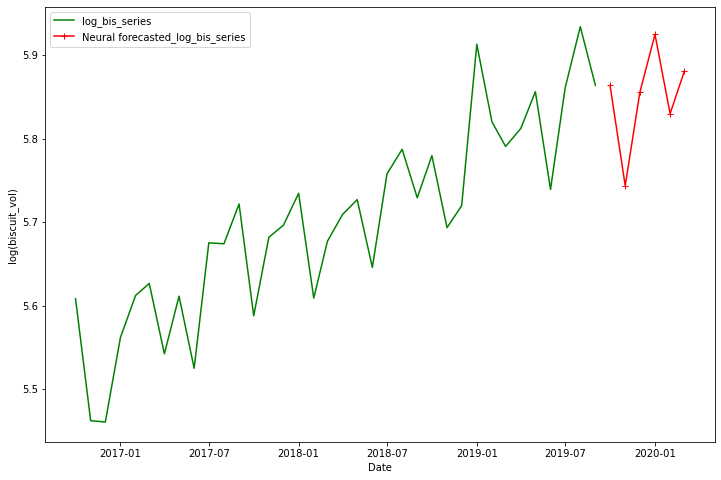

In [98]:
# Plotting the original & forecasted values of the log_bis series
# Displaying the True & Predicted values of the biscuit series
plt.figure(figsize=(12,8))
plt.plot(bis_log,color='green',label='log_bis_series')
plt.plot(forecast,color='red',marker='+',label='Neural forecasted_log_bis_series')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('log(biscuit_vol)')
plt.show()

### Conclusion:
### 1) The test set rmse of our tuned MLP model = 0.1738697, which is much more than the baseline rmse of 0.0512311 (corresponding to best naive model) and hence our MLP Neural Net  doesn't  seem to have any predictive power on this dataset.